<h1><center>CPU Performance Prediction</center></h1>

<img src="imgs/CPU intro pic.png" width="700">

Source: (Heddings, 2020)

# Problem Statement

"_Over the years various methods have been proposed for evaluating CPU performance._" (Yuan, 2018) <br>

A common method is to provide relative scores - know as Published Relative Performance (PRPs). This is a dimensionless manufacturer-provided metric. The methodology of determining these scores are often not known (Zhou, et al., n.d.) but may include "_benchmark speeds, user experience, and expert reviews._" (Yuan, 2018)

An example of this is from the 1980's "_where the magazine Computerworld would compare new CPUs to a well-known base model (IBM 370/158 Model 3). ... a relative score was then calculated indicating to the consumer how much better or worse than the IBM model the CPU was expected to be._" (Yuan, 2018)

"_Authors at the time examined whether the relative score for new models could be predicted directly from hardware specifications such as cache size and cycle time_" (Yuan, 2018) and that will be the purpose of this project - to do just that.

# Aim

To build a model that can predict CPU performance in terms of PRP scores, based on certain hardware specifications.

# Data

We have the data of 168 CPUs:<br>
- Each CPU has a PRP score. <br>
- Each CPU has 6 features: 
 - cache memory size, 
 - minimum number of I/O channels,
 - maximum number of I/O channels, 
 - machine cycle time, 
 - minimum main memory, and
 - maximum main memory.


# Import Necessary Libraries

In [1]:
# libraries for using data structure
import numpy as np
import pandas as pd

# libraries for data visualisation
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt     
%matplotlib inline

# libraries for optimisation
import scipy.optimize as opt
from sklearn.metrics import mean_squared_error

#libraries for maths and stats
import math
from scipy import stats
import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.outliers_influence import OLSInfluence
from statsmodels.graphics.regressionplots import plot_leverage_resid2
from patsy import dmatrices

# Obtain data

Let's put the predictor data (x-values) and response data (y-values) in a dataframe.

#### Predictor data

In [2]:
df_cpu = pd.read_csv('data/X.csv')

print(df_cpu.shape)

(168, 6)


In [3]:
df_cpu.head()

,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX
0,125,256,6000,256,16,128
1,29,8000,32000,32,8,32
2,29,8000,32000,32,8,32
3,29,8000,32000,32,8,32
4,26,8000,32000,64,8,32


#### Response data

In [4]:
# Obtain array of values of labels:

PRP = np.loadtxt('data/y.csv', delimiter=',', skiprows=1)[:,1]   # csv file, first row is headers, first column is id

print(np.shape(PRP))

(168,)


In [5]:
# Add array of values of labels to the dataframe:

df_cpu['PRP'] = PRP

In [6]:
# Put the response column in front:

# get a list of columns
cols = list(df_cpu)
# move the column to the front of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('PRP')))
# use loc to reorder
df_cpu = df_cpu.loc[:, cols]

In [7]:
df_cpu.head()

,PRP,MYCT,MMIN,MMAX,CACH,CHMIN,CHMAX
0,198.0,125,256,6000,256,16,128
1,269.0,29,8000,32000,32,8,32
2,220.0,29,8000,32000,32,8,32
3,172.0,29,8000,32000,32,8,32
4,318.0,26,8000,32000,64,8,32


# Data Exploration and Preparation

In [8]:
"""
Dataframe.melt 
is used to massage a DataFrame into such a format where
chosen independent variables (y-values) 
repeat, as they get paired up in turn with the 
chosen variables (x-values)

This makes it possible to turn a DataFrame that is multi-dimensional
into a multi-layered 2D plot
"""

# PRP become an identifier variables (id_var) (y value): 
# It becomes duplicated as it gets paired up with every independent (predictor) variable (x-value).

df_cpu_melt = pd.melt(df_cpu, id_vars=['PRP'])      
df_cpu_melt.head()

,PRP,variable,value
0,198.0,MYCT,125
1,269.0,MYCT,29
2,220.0,MYCT,29
3,172.0,MYCT,29
4,318.0,MYCT,26


Plot the response against every predictor

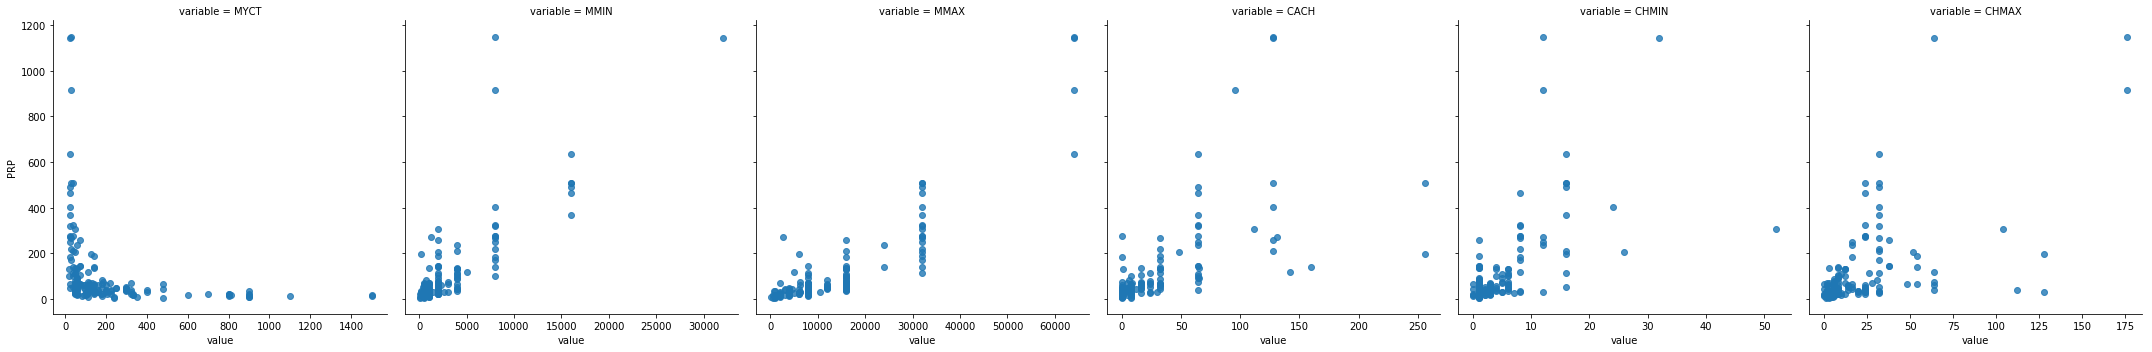

In [9]:
seaborn_grid = sns.lmplot(x = 'value', y = 'PRP', col='variable', data=df_cpu_melt, sharex=False, fit_reg=False)

If it is hard to make out, let's plot the graphs in columns of two.

In [10]:
def plot_two_rowed_figure(num_cols, num_rows, num_predictors, dataframe, response_name, log_scale=False):
    
    # Scatter plots of each independent variable against the dependent variable
    fig = plt.figure(figsize=(8*num_cols, 4*num_rows))

    for i in range(p):
        plot_number=i+1
        ax = fig.add_subplot(num_rows, num_cols, plot_number)
        ax.scatter(np.asanyarray(dataframe.iloc[:, i+1].tolist()), 
                   np.asanyarray(dataframe[response_name].tolist()), 
                   alpha=0.3)
        ax.set_title(response_name + " vs " + dataframe.columns[i+1])
        ax.set_xlabel(dataframe.columns[i+1])
        ax.set_ylabel(response_name)
        if log_scale == True:
            ax.set_yscale('log')
            ax.set_xscale('log')

    plt.tight_layout()    

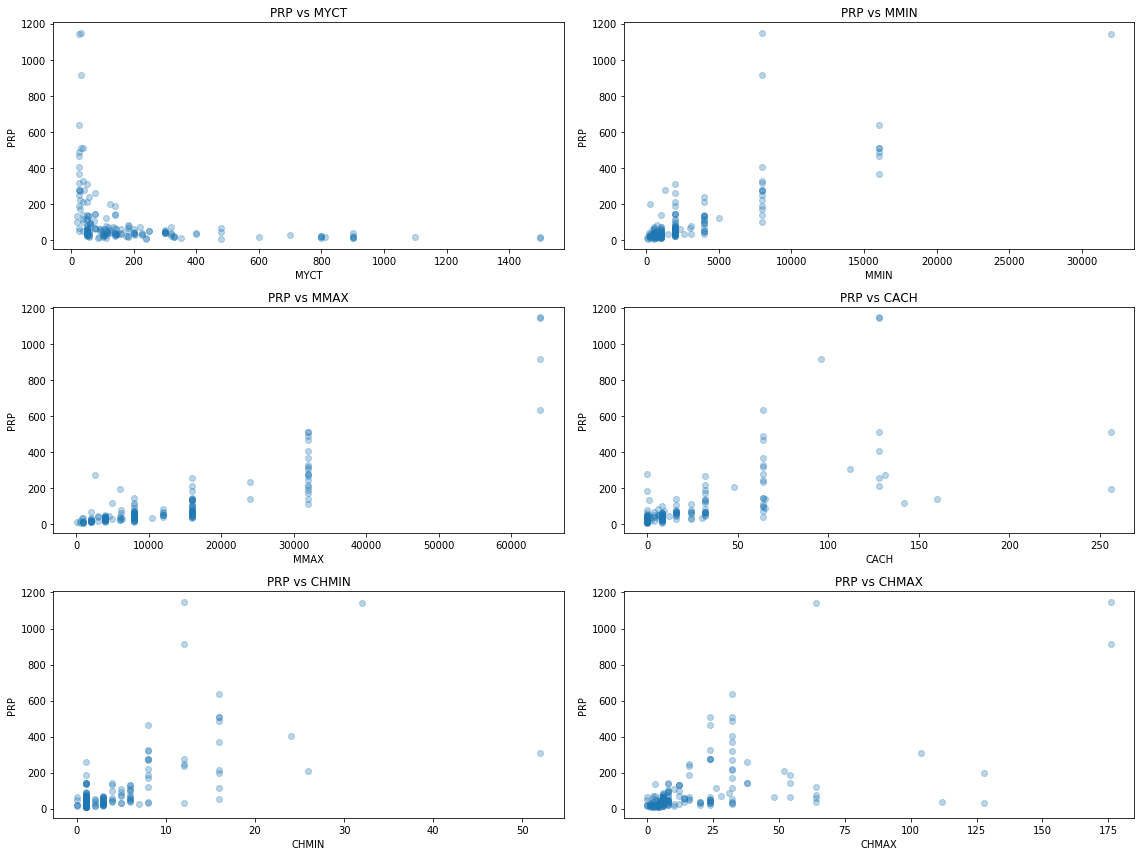

In [11]:
p = len(set(df_cpu_melt['variable'].tolist()))   # predictors (variables)

fig_cols = 2                                     # number of columns in the multifaceted figure
fig_rows = int(p / fig_cols)                     # number of rows in the multifaceted figure

# Scatter plots of the response against each predictor
plot_two_rowed_figure(fig_cols, fig_rows, p, df_cpu, 'PRP')

Normally when working with a large domain, it is better to **rescale** the x-values. Options include:<br>
- $x = \frac{(x-np.max(x))}{n}$
- $x = \frac{(x-np.mean(x))}{np.std(x)}$

However, here we can clearly see: The first graph is hyperbolic.<br> 
Perhaps it is better to convert our data to a **logarithmic scale**.

But before we do that, <br>
_the logarithm of zero is underfined_ which is problematic,<br>
hence, change the 0 values to very small values:

In [12]:
df_cpu = df_cpu.replace(0, 0.1, regex=True)

In [13]:
print(df_cpu.to_string())

        PRP  MYCT   MMIN   MMAX   CACH  CHMIN  CHMAX
0     198.0   125    256   6000  256.0   16.0  128.0
1     269.0    29   8000  32000   32.0    8.0   32.0
2     220.0    29   8000  32000   32.0    8.0   32.0
3     172.0    29   8000  32000   32.0    8.0   32.0
4     318.0    26   8000  32000   64.0    8.0   32.0
5     367.0    23  16000  32000   64.0   16.0   32.0
6     489.0    23  16000  32000   64.0   16.0   32.0
7     636.0    23  16000  64000   64.0   16.0   32.0
8    1144.0    23  32000  64000  128.0   32.0   64.0
9      38.0   400   1000   3000    0.1    1.0    2.0
10     92.0    60   2000   8000   65.0    1.0    8.0
11    138.0    50   4000  16000   65.0    1.0    8.0
12     10.0   350     64     64    0.1    1.0    4.0
13     35.0   200    512  16000    0.1    4.0   32.0
14     28.0   143    512   5000    0.1    7.0   32.0
15    120.0   110   5000   5000  142.0    8.0   64.0
16     30.0   143   1500   6300    0.1    5.0   32.0
17     33.0   143   3100   6200    0.1    5.0 

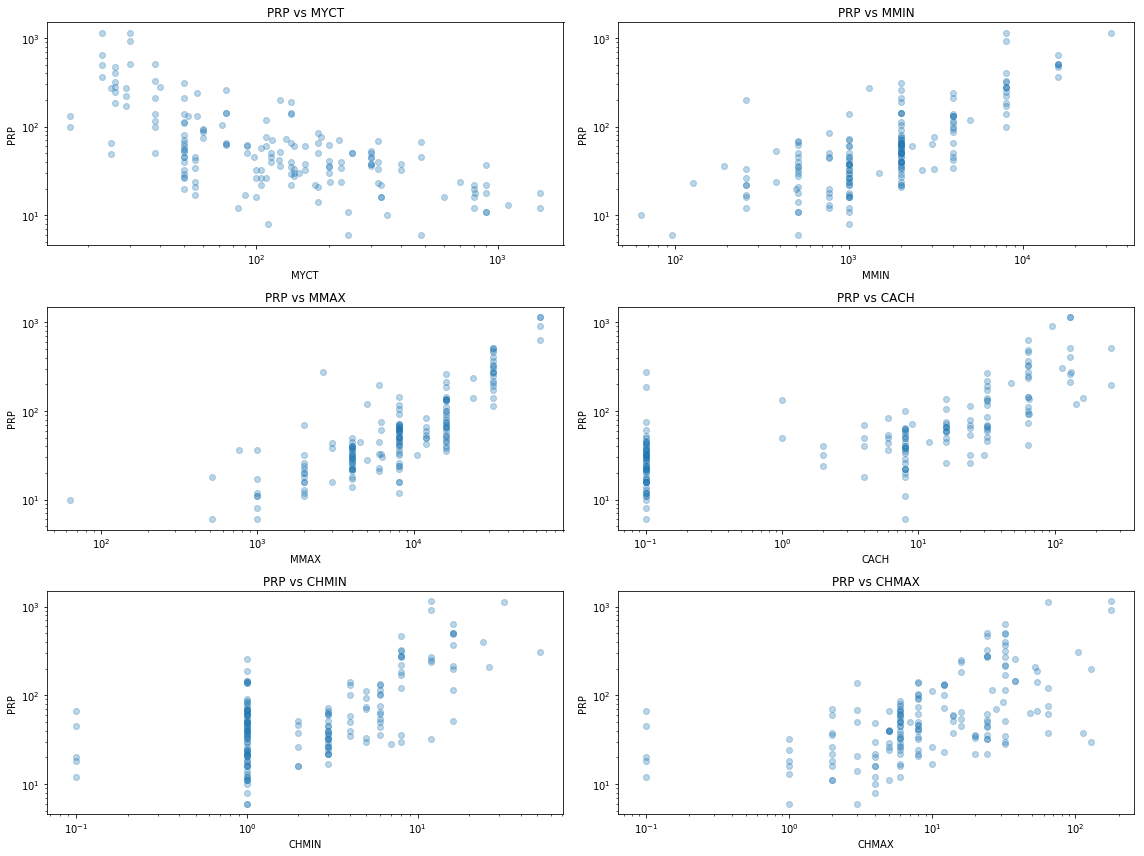

In [14]:
# Scatter plots of the response against each predictor
plot_two_rowed_figure(fig_cols, fig_rows, p, df_cpu, 'PRP', log_scale=True)

Now there seems to be linear trends

Let's convert the numbers to logarithms. Let's create another dataframe with these converted numbers.<br>
<u>Note</u>: np.log is the natural logarithm (ln)

In [15]:
df_cpu_log = df_cpu.apply(np.log)

In [16]:
print(df_cpu_log.to_string())     # inspect all the values, not just the top five with df.head()
                                  # makes sure there are no NaN or other strange values

          PRP      MYCT       MMIN       MMAX      CACH     CHMIN     CHMAX
0    5.288267  4.828314   5.545177   8.699515  5.545177  2.772589  4.852030
1    5.594711  3.367296   8.987197  10.373491  3.465736  2.079442  3.465736
2    5.393628  3.367296   8.987197  10.373491  3.465736  2.079442  3.465736
3    5.147494  3.367296   8.987197  10.373491  3.465736  2.079442  3.465736
4    5.762051  3.258097   8.987197  10.373491  4.158883  2.079442  3.465736
5    5.905362  3.135494   9.680344  10.373491  4.158883  2.772589  3.465736
6    6.192362  3.135494   9.680344  10.373491  4.158883  2.772589  3.465736
7    6.455199  3.135494   9.680344  11.066638  4.158883  2.772589  3.465736
8    7.042286  3.135494  10.373491  11.066638  4.852030  3.465736  4.158883
9    3.637586  5.991465   6.907755   8.006368 -2.302585  0.000000  0.693147
10   4.521789  4.094345   7.600902   8.987197  4.174387  0.000000  2.079442
11   4.927254  3.912023   8.294050   9.680344  4.174387  0.000000  2.079442
12   2.30258

Now let's look at the plots again with seaborn.

In [17]:
df_cpu_log_melt = pd.melt(df_cpu_log, id_vars=['PRP'])      
df_cpu_log_melt.head()

,PRP,variable,value
0,5.288267,MYCT,4.828314
1,5.594711,MYCT,3.367296
2,5.393628,MYCT,3.367296
3,5.147494,MYCT,3.367296
4,5.762051,MYCT,3.258097


/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

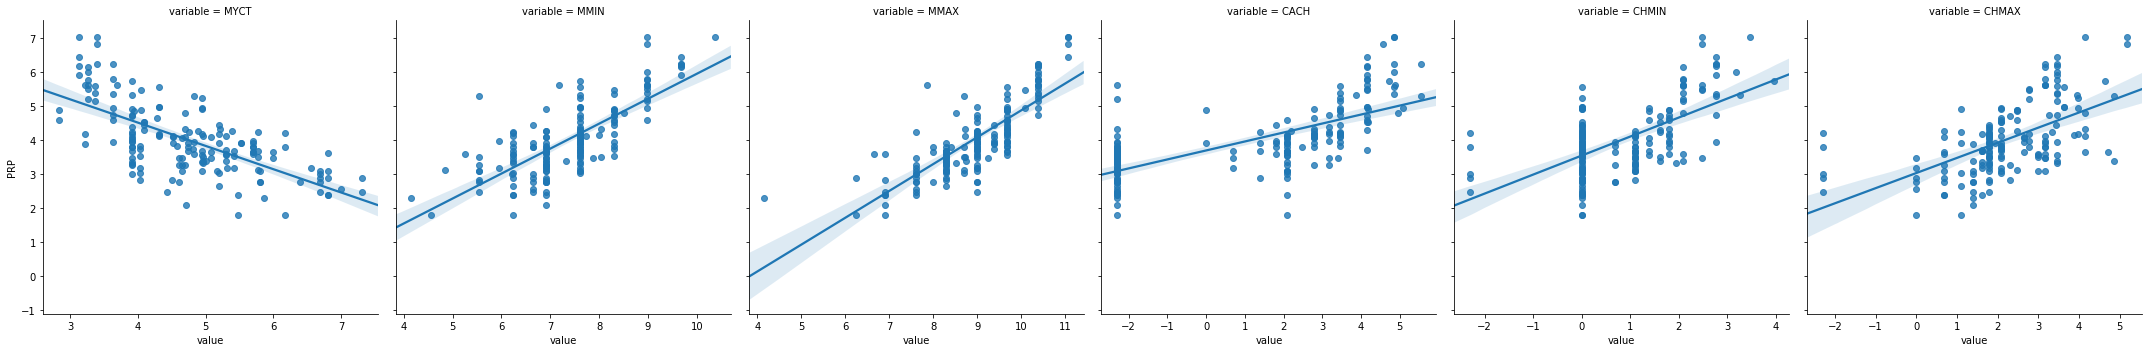

In [18]:
seaborn_grid = sns.lmplot(x = 'value', y = 'PRP', col='variable', data=df_cpu_log_melt, sharex=False, fit_reg=True)

Let's zoom into one of these at a time.

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


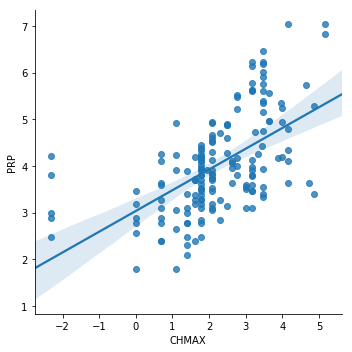

In [19]:
sns.lmplot(x='CHMAX', y='PRP', data=df_cpu_log)

We have successfully pre-processed the data so that linear regression is at least viable, even if not optimal.

# Split Training and Test Data

In order to perform basic **Simple Hold-Out Cross Validation**, we will split the data into $C$ sets:<br> We will train on $C-1$ sets, and test on the remaining set.<br>
As is standard: Let's choose $C=5$ and train on 80% of the data.

In [20]:
training_set_length = int(len(df_cpu_log)*0.80)

In [21]:
df_cpu_log_train = df_cpu_log.iloc[:training_set_length]
df_cpu_log_test = df_cpu_log.iloc[training_set_length:]

In [22]:
print(len(df_cpu_log))
print(len(df_cpu_log_train))
print(len(df_cpu_log_test))

168
134
34


# Foreword on Optimization

We will be attempting to fit a model to the training data in order to minimize loss. The lower the loss, the more optimal.<br>
We will train our model on the training data, and test its predictive strength on the test data.<br>
This will constitute our Machine Learning endeavour.<br><br>
We may try several different models and will use the appropriate analyses to help choose the best, but utlimately, the loss is the main metric.<br><br>
Before we start, there are some fundamentals about optimisation to understand.

Normally when it comes to optimisation, you have:
1. an **objective function**,<br> 
   This describes the loss that must be minimized<br>
   e.g. Mean Squared Error (MSE), Cross Entropy Error (CEE)<br><br>
   
2. an **algorithm**<br>
   This desribes a method of finding the minimum of an objective function, and more importantly, 
   what the parameters are at that minimum.<br>
   e.g. Linear Least Squares, Gradient Descent, Nelder-mead, BFGS<br><br>
 
3. an **optimizer**.<br>
   This is a software tool that takes the objective function and puts the algorithm into motion.
   e.g. scipy.optimize.minimize(…


# Multiple Linear Regression

## Matrix Calculations method

First lets put the data in Matrix format - create a **Design Matrix**<br>
For Univariable Regression (one predictor), the Design Matrix is:

$$\mathbf{X}=\begin{vmatrix}
1 & x_{1} & x_{1}^{2} & ⋯ & x_{1}^{K}\\
1 & x_{2} & x_{2}^{2} & ⋯ & x_{2}^{K}\\
⋮ & ⋮ & ⋮ & ⋱ & ⋮\\
1 & x_{n} & x_{n}^{2} & ⋯ & x_{n}^{K}
\end{vmatrix}$$

For Simple Linear Regression K = 1.<br><br>
For Multivariable (or Multiple) Regression, the Design Matrix becomes:

$$\mathbf{X}=\begin{vmatrix}
1 & x_{11} & x_{21} & ⋯ & x_{p1} & x_{11}^{2} & x_{21}^{2} & ⋯ & x_{p1}^{2} & ⋯ & x_{p1}^{K}\\
1 & x_{12} & x_{22} & ⋯ & x_{p2} & x_{12}^{2} & x_{22}^{2} & ⋯ & x_{p2}^{2} & ⋯ & x_{p2}^{K}\\
1 & x_{13} & x_{23} & ⋯ & x_{p3} & x_{13}^{2} & x_{23}^{2} & ⋯ & x_{p3}^{2} & ⋯ & x_{p3}^{K}\\
⋮ & ⋮ & ⋮ & ⋮ & ⋮ & ⋮ & ⋮ & ⋮ & ⋮ &⋱ & ⋮\\
1 & x_{1n} & x_{2n} & ⋯ & x_{pn} & x_{1n}^{2} & x_{2n}^{2} & ⋯ & x_{pn}^{2} & ⋯ & x_{pn}^{K}\\
\end{vmatrix}$$

$x_{ij}$ is the variable for predictor $i$ at data point $j$.<br>
Going down the matrix we move across the domain: the first [data] point, the second point … the n-th point.<br>
Going accross matrix we stay at one point in the domain: predictor 1, predictor 2, ... predictor 1 squared, predictor 2 squared ...

Let's start with Multivariable Linear Regression

In [23]:
# extract the predictors data and put it in an array
predictors_array_train = df_cpu_log_train.iloc[:, 1:].to_numpy()   # skip the first column which is the response  
print(np.shape(predictors_array_train))

(134, 6)


In [24]:
# stack a column of ones with the array of predictors data... to create our Design Matrix
X_design_train = np.hstack((np.ones(np.shape(predictors_array_train[:,1]))[:,None], 
                            predictors_array_train))

In [25]:
np.shape(X_design_train)

(134, 7)

Lets also put the response data in an array

In [26]:
y_train = np.asanyarray(df_cpu_log_train['PRP'].tolist())

In [27]:
np.shape(y_train)

(134,)

Let's create the same arrays for our test data

In [28]:
predictors_array_test = df_cpu_log_test.iloc[:, 1:].to_numpy()
X_design_test = np.hstack((np.ones(np.shape(predictors_array_test[:,1]))[:,None],
                           predictors_array_test))
y_test = np.asanyarray(df_cpu_log_test['PRP'].tolist())

For our (1) **Objective Function** let's choose the Mean Squared Error

$$L = \frac{1}{n}\sum_{i=1}^{n} (y_{i}-f(x_{n};w_{0},w_{1}))^{2}$$

But this equation only works for Simple Linear Regression, so...<br>
... if using Matrix Notation

$$L=\frac{1}{n}(\mathbf{y}-\mathbf{Xw})^{2}$$

where:<br>
**y** is the matrix of responses<br>
**X** is the Design Matrix<br>
**w** is the coefficients matrix

In [29]:
# Define the loss function
def loss_lin(w, X, y): 
    L = np.mean( (y-np.dot(X, w))**2 ) # the average squared loss function
    return(L)

For our (2) **Algorithm** let's try two options. First lets try Linear Least Squares:

For Least Squares for Linear Regression, there is no need for an optimizer (3). You can solve for the coefficients by directly solving this equation:

$$\hat{\mathbf{w}}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{y}$$

In [30]:
def least_square(X, y): # np.linalg.solve, np.dot
    return( np.linalg.solve(np.dot(X.T,X),np.dot(X.T,y)) )

So let's solve for it

In [31]:
w_least = least_square(X_design_train, y_train)

In [32]:
print(w_least)

[-0.82914493  0.01584773  0.26678244  0.26136064  0.1178309   0.15001514
  0.09453073]


Lets calculate the **loss**

In [33]:
loss_ls = loss_lin(w_least, X_design_test, y_test)
print(loss_ls)

0.338678236391868


For our (2) **Algorithm** we could also try Gradient Descent.

$$\theta^{(i+1)}=\theta^{(i)}-\delta∇L(\theta^{(i)})$$

The basic option would be to repeat $w_i = w_i - \alpha \frac{\partial L(w_0, w_1)}{\partial w_i} $ until convergence.<br>However, let's choose BFGS as our algorithm, which is an algorithm that departs from Gradient Descent. 

But first we need a function for the gradient

$$\frac{dL(\mathbf{w})}{d\mathbf{w}}=-\frac{2}{n}(\mathbf{X}^{T}\mathbf{y}-\mathbf{X}^{T}\mathbf{X}\mathbf{w})$$

In [34]:
def gradient(w, X, y): # define the gradient function
    g = np.zeros(np.shape(X)[1])
    for i in range(np.shape(X)[1]):
        g[i] = -np.mean(2*(y-np.dot(X,w))*X[:,i])
    return(g)

In [35]:
w0 = np.ones((X_design_train.shape[1], 1))[:, 0]

# This checks if your gradient function is correct by comparing it with numerical approximation
eps    = 1e-4 # step size 
mygrad = gradient(w0, X_design_train, y_train)
fdgrad = np.zeros(w0.shape)
for d in range(len(w0)): # pertub each dimension in term
    mask = np.zeros(w0.shape) # a binary mask that only allows selected dimension to change
    mask[d]   = 1
    fdgrad[d] = (loss_lin(w0 + eps*mask, X_design_train, y_train) - loss_lin(w0 - eps*mask, X_design_train, y_train))/(2*eps) # definition of gradient

print("THIS IS FOR GRADIENT DESCENT:")    
print("MYGRAD: ", mygrad) # my gradient output
print("FDGRAD: ", fdgrad) # numerical gradient
print("Error: ", np.linalg.norm(mygrad-fdgrad)/np.linalg.norm(mygrad+fdgrad) ) # error 


res = opt.minimize(loss_lin, w0, args=(X_design_train, y_train), method='BFGS', jac=gradient, 
                   options={'gtol': 1e-7, 'disp': True})


w_fit = res.x

THIS IS FOR GRADIENT DESCENT:
MYGRAD:  [ 44.03639687 205.36748856 328.21169282 396.2150779   64.48667222
  40.3032594  103.44744699]
FDGRAD:  [ 44.03639687 205.36748856 328.21169282 396.2150779   64.48667222
  40.3032594  103.44744699]
Error:  3.444611410084135e-13
Optimization terminated successfully.
         Current function value: 0.198405
         Iterations: 25
         Function evaluations: 28
         Gradient evaluations: 28


In [36]:
print(w_fit)

[-0.82914494  0.01584773  0.26678244  0.26136064  0.1178309   0.15001514
  0.09453073]


Lets calculate the **loss**

In [37]:
loss_gd = loss_lin(w_fit, X_design_test, y_test)
print(loss_gd)

0.33867823646706074


Question: Is the loss produced by using the Least Squares Method, lower (better) than the loss produced by using the Gradient Descent Method?

In [38]:
# Is the least squares loss smaller (is least squares better)?
loss_ls < loss_gd

True

In [39]:
lowest_loss = loss_ls

## Statsmodels method

The statsmodel library has the ability to make the fit for us without us working with matrix calculations. It also provides some other useful insights. Let's use it now and see if it corresponds with our work so far.

In [40]:
formula = 'PRP ~ ' + " + ".join(df_cpu_log.columns[1:])
formula

'PRP ~ MYCT + MMIN + MMAX + CACH + CHMIN + CHMAX'

<u>Note:</u> Make sure you have patsy version 0.5.1 installed. statsmodels uses patsy for parsing formulas and creating design matrices

In [41]:
import patsy
patsy.__version__

'0.5.1'

In [42]:
results = smf.ols(formula, data=df_cpu_log_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PRP   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.796
Method:                 Least Squares   F-statistic:                     87.29
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           1.20e-42
Time:                        22:37:06   Log-Likelihood:                -81.769
No. Observations:                 134   AIC:                             177.5
Df Residuals:                     127   BIC:                             197.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.8291      0.660     -1.256      0.211      -2.136       0.477
MYCT           0.0158      0.058      0.272      0.786      -0.099       0.131
MMIN           0.2668      0.061      4.374      0.000       0.146       0.387
MMAX           0.2614      0.060      4.379      0.000       0.143       0.379
CACH           0.1178      0.019      6.193      0.000       0.080       0.155
CHMIN          0.1500      0.059      2.563      0.012       0.034       0.266
CHMAX          0.0945      0.046      2.069      0.041       0.004       0.185
==============================================================================
Omnibus:                        0.619   Durbin-Watson:                   1.118
Prob(Omnibus):                  0.734   Jarque-Bera (JB):                0.485
Skew:                           0.147   Prob(JB):                        0.784
Kurtosis:                       3.005   Cond. No.                         215.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

As we can see statsmodels assigned the same coefficients we obtained from doing the matrix calculations ourselves.

Let's interpret these numbers.<br>

- **coefficient**: <br>Looking at CACH:<br> According to our approximations, an additional cach memory size of $e^{1}=2.72$ is, on average, associated with an increase in PRP by $e^{0.1178}=1.125$.

- **std error**: <br>The standard error tells us, per coefficient, how accurate our estimation is. The more samples, the less biased and the less the standard error.<br> The standard error also helps us calculate the confidence interval.<br>
The standard error also helps us calculate the t-statistic for hypothesis testing.

<img src="imgs/Confidence Level.png" width="800">

- **confidence interval**: <br>
Looking at the intercept: <br>
The 95% confidence interval tells us that:<br>In the absence of any memory, cycle time and I/O channels, the PRP will, on average, lie between $e^{-2.136}=0.12$ and $e^{0.477}=1.61$.<br><br>
Looking at CACH: <br>The 95% confidence interval tells us:<br>
For each increase in cach memory size of $e^{1}=2.72$, there will be an increase in PRP of between $e^{0.08}=1.08$ and $e^{0.155}=1.167$<br>
<u>Note:</u> If a coefficient's confidence interval contains zero, there is a possibility that the predictor has no relationship with the response variable or it is simply insignificant in terms of its influence on the response variable.<br><br>
Looking at the intercept and MYCT, both have their confidence intervals crossing zero.<br>However, when it comes to the intercept, it is best not to remove it. "*If the intercept is not significant you usually would not want to remove it from the model because by doing this you are creating a model that says that the response function must be zero when the predictors are all zero.*" (SAS, n.d.)<br><br>
<u>Conclusion</u>: We could remove MYCT.

- **t-statistic**:<br>
The Null Hypothesis ($ H_{0} $) is that there is no relationship between predictor and response i.e. $H_{0}: \beta_{1}=0$. <br>
This is a univariable pair-wise comparison between predictor and response.<br>
The greater the magnitude of the t-statistic value, the greater the evidence against the null hypothesis.<br>
How large is large enough? For that, arguably it is better to look at the p-values.<br>
This t-statistic has a distribution, called the t-distribution.

$$t=\frac{\hat\beta_{1}-0}{SE(\hat\beta_{1})}$$

- **P>[t]**:<br>The probability we are interested in here, is the p-value ($P>[t]$).<br>The p-value is the probability of obtaining results as extreme as the observed results of a statistical hypothesis test, assuming that $ H_{0} $ is correct.<br>
If the p-value is sufficiently small, there is a relationship and we can reject $ H_{0} $.<br>
The p-value cutoffs for rejecting the null hypothesis are 5% or 1%. For us, a p-value of less than 0.05 is considered to be statistically significant.<br><br>
Looking at the Intercept:<br>
It seems that it is not statistically significant. However, it is best not to remove it, as explained earlier.<br><br>
Looking at MYCT:<br>
The p-value is more than 0.05, hence it is not statistically significant. Hence, it is a good idea to remove it.<br><br><u>Conclusion</u>: We could remove the predictor MYCT.

- **F-statistic**:<br>
    The Null Hypothesis $(H_{0})$ in Multivariable regression states that there is no relationship between the response and all the p predictors i.e. $H_{0} : \beta_{1} = \beta_{2}= ... = \beta_{p} = 0$. You can still calculate the t statistic and p-values between the response and each predictor seperately but that can be misleading, especially when the number of variables is large (e.g. n = 100). (James, et al., 2017) In this case, though, it isn't.<br>
    If the F-statistic is close to 1, we don’t reject $H_{0}$.<br>
If the F-statistic is not close to 1, we do reject $H_{0}$ - there are relationships.<br>
<br>
The F-statistic has a distribution called the F-distribution.<br><br>
<u>Conclusion:</u> We do reject $H_{0}$ - there are relationships.

- **$R^{2}$**<br>
$R^{2}$ measures the proportion of variability in Y that can be explained by the regression (model). It ranges between 0 and 1, with the closer to 1 the better. <br>
It is a dimensionless number similar to correlation.<br>
<u>Note:</u> Correlation helps determine the relationship between X and Y, but correlation only works really for one pairwise comparison at a time. It is not so good for Multivariable regression.<br>
Adjusted $R^{2}$ adjusts the statistic based on the number of independent variables in the model.
Looking at the stats:<br>
The $R^{2}$ and Adjusted $R^{2}$ are both around 0.8, which is good - 80% of the variance in the data can be explained by the model. Arguably, at around 60% it starts becoming too low.<br><br>
<u>Conclusion:</u> The model variance is good - it is not too biased (underfit).

Useful stats, not shown above:

- RSE:<br>
RSE measures the lack of fit in Y. The lower the better.

In [43]:
y_test_pred = np.dot(X_design_test,w_least)

mse = mean_squared_error(y_test, y_test_pred)
rse = math.sqrt(mse/(len(df_cpu_log_train)-2))

print(rse)

0.05065317576509798


Thus, PRP for each CPU deviates from the true regression by approximately $e^{0.0506}=1.05$, on average.<br>
Even if the model were correct and the true values of the unknown coefficients were known exactly, any prediction of the PRP would still be off by about $e^{0.0506}=1.05$ on average.
Whether this is acceptable or not is up for debate, but in this context, seem sufficiently low.

## Question: Is there a Relationship between Response and Predictors?

Looking at the F-statistic, the answer is yes.<br>

## Question: How strong is the Relationship?

Looking at $R^{2}$ it is high - the model can explain the variance in response values. Thus, there is a strong relationship.<br>
Looking at RSE it seems low - errors made were not substantial. Thus, the lack of fit is high - there is a strong relationship.

## Question: Which predictors contribute to the Outcome?

Looking at the p-values associated with each predictor's t-statistic:<br>
MMIN<br>
MMAX<br>
CACH<br>
CHMIN<br>
CHMAX

## Lets remove the statistically insignificant variables

In [44]:
formula = 'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX'
formula

'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX'

In [45]:
results = smf.ols(formula, data=df_cpu_log_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PRP   R-squared:                       0.805
Model:                            OLS   Adj. R-squared:                  0.797
Method:                 Least Squares   F-statistic:                     105.5
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           1.15e-43
Time:                        22:37:06   Log-Likelihood:                -81.808
No. Observations:                 134   AIC:                             175.6
Df Residuals:                     128   BIC:                             193.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6902      0.417     -1.653      0.101      -1.516       0.136
MMIN           0.2609      0.057      4.594      0.000       0.149       0.373
MMAX           0.2600      0.059      4.387      0.000       0.143       0.377
CACH           0.1167      0.019      6.297      0.000       0.080       0.153
CHMIN          0.1467      0.057      2.572      0.011       0.034       0.260
CHMAX          0.0928      0.045      2.058      0.042       0.004       0.182
==============================================================================
Omnibus:                        0.539   Durbin-Watson:                   1.109
Prob(Omnibus):                  0.764   Jarque-Bera (JB):                0.449
Skew:                           0.141   Prob(JB):                        0.799
Kurtosis:                       2.977   Cond. No.                         127.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

After removing MYCT, the statistical significance of the intercept has improved.

## Question: How large is the effect of each predictor on the response?

For this you look at the coefficients and the confidence level of the coefficients of each predictor.

## Question: Is the relationship linear?

Residual plots are a useful graphical tool for identifying non-linearity.<br> 
We can plot the residuals, $ e_{i} = y_{i} - \hat{{y}}_1$ versus the predicted (or fitted) values $ \hat{y}_{i} $.
Ideally, the residual plot will show no discernible pattern.<br>

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


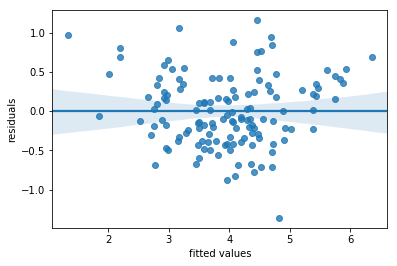

In [46]:
ax = sns.regplot(results.fittedvalues, results.resid)
ax.set(xlabel='fitted values', ylabel='residuals')
plt.show()

Ideally you want the residual plot to be a horizontal line through the origin. If it is, then it means linear regression might suffice.<br><br>
<u>Conclusion:</u> Linear Regression seems to suffice.

Another observation one can make when looking at this plot is whether **heteroscedacity** is an issue - the non-constant variance of error terms. This would happen, for example, if the fitted line in the graph above is at $y = 0$ (as it is above), however, the data points funnel out (widen more and more). In those cases a concave function such as $\log{y}$ or $\sqrt{y}$ is necessary.<br>
In this case, heteroscedacity is not a problem, possibly because we have already transformed our predictors and responses logarithmically.

## Question: What other effects do the variables have on each other?

Answering these questions allows us to further improve our model by either identifying new terms or eliminating problems caused by existing terms.

### Is there a synnergy effect between variables?

Cache memory is used to reduce the average time to access data from the main memory. The cache is a smaller and faster memory which stores copies of the data from frequently used main memory locations. (Geeks for Geeks, 2020) "*When the processor needs to read or write a location in main memory, it first checks for a corresponding entry in the cache.*" (Geeks for Geeks, 2020) <br>
The   input/output   (I/O)   channels   provide   for communications  between  the  CPU  and  all  peripheral devices e.g. monitor.<br><br>
Perhaps there are some synnergystic relationships here: 
- The more channels you have, the more cache memory can be provided, making it more effective (CHMAX, CACH).
- The more channels you have, the more main memory can be provided, making it more effective (CHMAX, MMAX).

Let's investigate the first proposed synnergistic effect:

In [47]:
formula = 'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH'
formula

'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH'

In [48]:
results = smf.ols(formula, data=df_cpu_log_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PRP   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.812
Method:                 Least Squares   F-statistic:                     96.59
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           6.73e-45
Time:                        22:37:06   Log-Likelihood:                -76.259
No. Observations:                 134   AIC:                             166.5
Df Residuals:                     127   BIC:                             186.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.6962      0.402     -1.732      0.086      -1.492       0.099
MMIN           0.2346      0.055      4.246      0.000       0.125       0.344
MMAX           0.2782      0.057      4.851      0.000       0.165       0.392
CACH           0.0283      0.032      0.880      0.380      -0.035       0.092
CHMIN          0.1575      0.055      2.861      0.005       0.049       0.266
CHMAX          0.0887      0.043      2.041      0.043       0.003       0.175
CHMAX:CACH     0.0366      0.011      3.312      0.001       0.015       0.058
==============================================================================
Omnibus:                        2.006   Durbin-Watson:                   1.272
Prob(Omnibus):                  0.367   Jarque-Bera (JB):                1.684
Skew:                           0.055   Prob(JB):                        0.431
Kurtosis:                       3.538   Cond. No.                         138.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<u>Conclusion:</u><br>
It seems from the p-value that this synnergystic relationship is statistically significant.<br>
Furthermore, the fit improved, looking at $R^{2}$ and the adjusted $R^{2}$.<br><br>
It seems that the p-value for CACH has increased to a place where it is statistically insignificant now. <br>
However, we cannot keep CHMAX\*CACH and discard CACH: The *hierarchical principle* states that if we include an interaction in a model, we should also include the main effects, even if the p-values associated with their coefficients are not significant.

Let's investigate the second proposed synnergistic effect:

In [49]:
formula = 'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * MMAX'
formula

'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * MMAX'

In [50]:
results = smf.ols(formula, data=df_cpu_log_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PRP   R-squared:                       0.820
Model:                            OLS   Adj. R-squared:                  0.811
Method:                 Least Squares   F-statistic:                     96.23
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           8.16e-45
Time:                        22:37:06   Log-Likelihood:                -76.464
No. Observations:                 134   AIC:                             166.9
Df Residuals:                     127   BIC:                             187.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.9949      0.657      1.515      0.132      -0.305       2.295
MMIN           0.2068      0.057      3.613      0.000       0.094       0.320
MMAX           0.0972      0.076      1.278      0.203      -0.053       0.248
CACH           0.1155      0.018      6.455      0.000       0.080       0.151
CHMIN          0.1596      0.055      2.893      0.004       0.050       0.269
CHMAX         -0.6732      0.240     -2.807      0.006      -1.148      -0.199
CHMAX:MMAX     0.0909      0.028      3.247      0.001       0.035       0.146
==============================================================================
Omnibus:                        1.630   Durbin-Watson:                   1.315
Prob(Omnibus):                  0.443   Jarque-Bera (JB):                1.219
Skew:                           0.068   Prob(JB):                        0.544
Kurtosis:                       3.447   Cond. No.                         468.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Again, by looking at the p-value, the interactive term seems to be statistically significant.<br>
Also, the metrics of $R^{2}$ and the adjusted $R^{2}$ improved to a similar place compared to the previous formula.

What if we combined both - added both interactive terms.

In [51]:
formula = 'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH + CHMAX * MMAX'
formula

'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH + CHMAX * MMAX'

In [52]:
results = smf.ols(formula, data=df_cpu_log_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PRP   R-squared:                       0.824
Model:                            OLS   Adj. R-squared:                  0.814
Method:                 Least Squares   F-statistic:                     84.25
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           1.88e-44
Time:                        22:37:06   Log-Likelihood:                -74.861
No. Observations:                 134   AIC:                             165.7
Df Residuals:                     126   BIC:                             188.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.3411      0.751      0.454      0.651      -1.146       1.828
MMIN           0.2107      0.057      3.707      0.000       0.098       0.323
MMAX           0.1717      0.087      1.982      0.050       0.000       0.343
CACH           0.0588      0.037      1.588      0.115      -0.014       0.132
CHMIN          0.1617      0.055      2.952      0.004       0.053       0.270
CHMAX         -0.3804      0.291     -1.307      0.194      -0.956       0.196
CHMAX:CACH     0.0237      0.014      1.747      0.083      -0.003       0.050
CHMAX:MMAX     0.0558      0.034      1.630      0.106      -0.012       0.124
==============================================================================
Omnibus:                        2.458   Durbin-Watson:                   1.329
Prob(Omnibus):                  0.293   Jarque-Bera (JB):                2.317
Skew:                           0.038   Prob(JB):                        0.314
Kurtosis:                       3.640   Cond. No.                         556.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Now, both interactive terms are statistically insignificant.<br>
The reason for this is that collinearity is causing havoc here. The two interactive terms are too correlated.<br>
Hence we have two options:

In [53]:
formula_option_1 = 'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH'
formula_option_2 = 'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * MMAX'

For now let's go with option 1, since its results were slightly better.

In [54]:
formula = formula_option_1
print(formula)

PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH


### Is there collinearity or multi-colinearity? 

#### Collinearity

Between response and predictors we want high correlation.<br>
Between predictors we don't want high correlation because then it becomes difficult to tell which ones are explaining the variation in response:<br>
<u>Example:</u> Two people are pushing a car up a hill. You want to know how hard each of them is pushing (contributing). Suppose that you watch them push together for ten minutes and the car moves 5 feet. Did the first guy do all the work and the second just fake it? Or vice versa?

<u>Note:</u> You want to account for synnergy between variables before you are worried about collinearity, because if there is a synnergystic effect, its best not to eliminate it by looking at variables that may cause [multi]-collinearity first. Hence, we address the topics in the right order here.

Let's look at correlations:

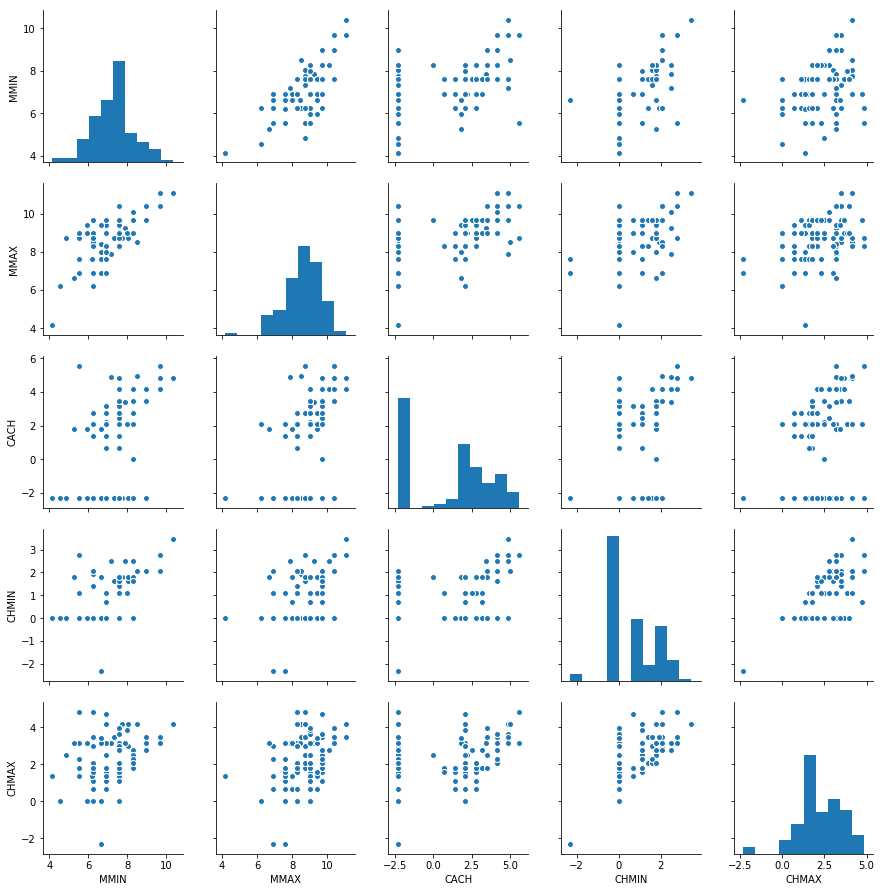

In [55]:
sns.pairplot(df_cpu_log_train.iloc[:,2:])

In [56]:
df_cpu_log_train.iloc[:,2:].corr()

,MMIN,MMAX,CACH,CHMIN,CHMAX
MMIN,1.000000,0.720925,0.512158,0.496292,0.349510
MMAX,0.720925,1.000000,0.579145,0.424343,0.464093
CACH,0.512158,0.579145,1.000000,0.329307,0.366214
CHMIN,0.496292,0.424343,0.329307,1.000000,0.693471
CHMAX,0.349510,0.464093,0.366214,0.693471,1.000000


There seems to be some correlation between<br> 
- MMIN and MMAX
- CHMIN and CHMAX

This might suggest removing one of the correlated variables (e.g. MMIN and CHMIN) would be a good idea.<br>However, considering the p-values, these are statistically significant terms and should rather not be removed.<br>
We could experiment and remove MMIN and/or CHMIN. For now, we will consider a correlation of around 0.7 to be acceptable and move on.

Unfortunately, not all collinearity problems can be detected by inspection of the correlation matrix: it is possible for collinearity to exist between three or more variables even if no pair of variables has a particularly high correlation i.e. more than two predictors are inter-correlated.<br>
We call this situation multi-collinearity.

#### Multi-Collinearity

As already mentioned, sometimes collinearity can exist between three or more variables even if no pair of variables has a particularly high correlation.<br>

Why is multi-collinearity so bad?<br>
When there is a high correlation amongst predictor variables, it leads to "*unreliable and unstable estimates of regression coefficients.*" (Allison, 2012). This is clearly not good. The model's interpretability is compromised. Furthermore, it leads to wide confidence (and prediction) intervals.

Instead of inspecting the correlation matrix, it is probably best to compute the **Variance Inflation Factor (VIF)**

In [57]:
def VIF(dataframe, formula): 
    y_df, X_design_df = dmatrices(formula, data=dataframe, return_type='dataframe')   # calculate the design matrix

    #calculate VIF for each explanatory variable
    vif = pd.DataFrame()
    vif['VIF'] = [variance_inflation_factor(X_design_df.values, i) for i in range(X_design_df.shape[1])]
    vif['variable'] = X_design_df.columns

    #view VIF for each explanatory variable 
    return(vif)

In [58]:
VIF(df_cpu_log_train, formula)

,VIF,variable
0,112.354404,Intercept
1,2.526088,MMIN
2,2.625866,MMAX
3,5.105419,CACH
4,2.295138,CHMIN
5,2.202372,CHMAX
6,4.598186,CHMAX:CACH


The smallest possible value for VIF is 1, which indicates the complete absence of collinearity. "*A VIF of 1.8 tells us that the variance (the square of the standard error) of a particular coefficient is 80% larger than it would be if that predictor was completely uncorrelated with all the other predictors.*" (Allison, 2012) <br>
Typically if the VIF exceeds 5 it is too much.<br><br>
The intercept VIF is too high, but we can't eliminate intercept.<br>
The CACH VIF is perhaps just too high. We could try the other formula option where the interactive terms did not involve CACH.

In [59]:
formula = formula_option_2
print(formula)

PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * MMAX


In [60]:
VIF(df_cpu_log_train, formula)

,VIF,variable
0,298.912578,Intercept
1,2.702565,MMIN
2,4.602389,MMAX
3,1.577633,CACH
4,2.299006,CHMIN
5,66.931634,CHMAX
6,81.014560,CHMAX:MMAX


Considering the high VIF numbers, clearly this is not a good option.<br>
Also, as could have been noticed earlier, the **Condition number** increased in formula option 2 (from 138 to 468). <br>
If the Condition number is large (e.g. 1.51x10^4) then this might indicate that there is strong multicollinearity or other numerical problems. It was not that large, but it did increase.<br> 

Let's look if mulit-collinearity existed without the interactive terms added

In [61]:
formula = 'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX'
VIF(df_cpu_log_train, formula)

,VIF,variable
0,112.352084,Intercept
1,2.474147,MMIN
2,2.601718,MMAX
3,1.576880,CACH
4,2.287076,CHMIN
5,2.200561,CHMAX


Fortunately, multi-collinearity seems to only be introduced with the interactive terms.<br>
<u>Note:</u> If multi-collinearity existed between the main terms, the only way to eliminate it would be through **PCA**.<br><br>
Hence:

In [62]:
formula = formula_option_1
print(formula)

PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH


In [63]:
results = smf.ols(formula, data=df_cpu_log_train).fit()

Let's calculate the new loss

First let's create the Design Matrix using our chosen predictors (formula), and also the response array:

In [64]:
y_train_df, X_design_train_df = dmatrices(formula, data=df_cpu_log_train, return_type='dataframe')

X_design_train = X_design_train_df.to_numpy()
print(np.shape(X_design_train))

(134, 7)


In [65]:
y_train = y_train_df.to_numpy()
print(np.shape(y_train))

(134, 1)


Then let's use the Least Squares Method (which worked out best earlier) to obtain the coefficients matrix:

In [66]:
w_least = least_square(X_design_train, y_train)[:,0]
print(w_least)

[-0.69623131  0.23461685  0.2781751   0.02828025  0.15753885  0.08866059
  0.03659422]


Then let's transform our test data in a similar fasion to a Design Matrix for X and response array for Y:

In [67]:
y_test_df, X_design_test_df = dmatrices(formula, data=df_cpu_log_test, return_type='dataframe')

X_design_test = X_design_test_df.to_numpy()
print(np.shape(X_design_test))

(34, 7)


Finally we can calculate the loss

In [68]:
loss_ls = loss_lin(w_least, X_design_test, y_test)
print(loss_ls)

0.3039902355620048


Question: Is the loss produced by this method the lowest so far?

In [69]:
loss_ls < lowest_loss

True

In [70]:
lowest_loss = loss_ls

The loss achieved is the best thus far.

## Question: Are there any outliers or high-leverage points?

A statistical outlier: 
- does not effect the fit of the model, but
- can drastically increase the RSE (e.g. from 0.77 to 1.09). 
- can cause the decline of the $R^{2}$ statistic (e.g. from 0.892 to 0.805)

Let's go back to the initial dataframe that held our data and see if any of the observations is out of the ordinary compared to others

In [71]:
results = smf.ols(formula, data=df_cpu_log_train).fit()

results_influence = OLSInfluence(results)

In [72]:
print(results_influence)

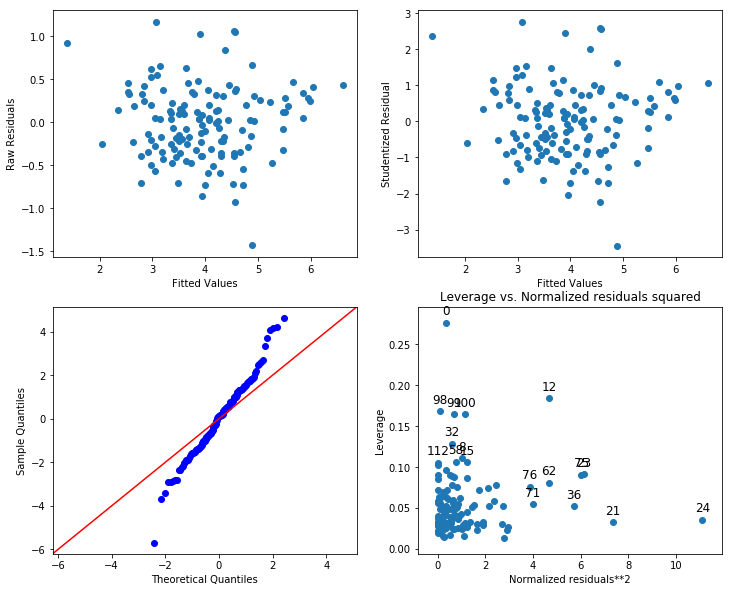

In [73]:
# make four diagnostics plots
fig, ax = plt.subplots(2, 2, figsize=(12,10))                # make a 2x2 plot

# making the residual plot (top left)
ax[0, 0].scatter(results.fittedvalues, results.resid)         
ax[0, 0].set_ylabel("Raw Residuals")
ax[0, 0].set_xlabel("Fitted Values")

# making a studentized residual plot (top right)
ax[0, 1].scatter(results.fittedvalues, results_influence.resid_studentized_external)
ax[0, 1].set_ylabel("Studentized Residual")
ax[0, 1].set_xlabel("Fitted Values")

# qq plot (bottom left)
sm.graphics.qqplot(results.resid / np.sqrt((results.resid ** 2).sum() / 390), line='45', ax=ax[1, 0]);

# leverage plot (bottom right)
plot_leverage_resid2(results, ax = ax[1, 1]);

- **Raw residuals vs Fitted values**<br>

/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


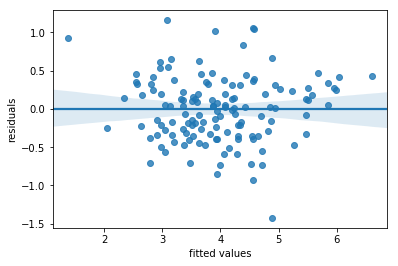

In [74]:
ax = sns.regplot(results.fittedvalues, results.resid)
ax.set(xlabel='fitted values', ylabel='residuals')
plt.show()

Again, ideally you want the residual plot to have a regression line as a horizontal line through the origin - you want there to be no discernable pattern.<br>
Since it does, it means there is a linearity in the data and we have a good fit.<br>
However, the graph does show that some data points are far out from the others, but how far out must it be to be considered an outlier? This is where the studentized residuals help.

- **Studentized residuals vs Fitted values**<br>
Studentized residuals are computed by dividing each residual $e_{i}$ by its estimated standard error.<br> Observations whose studentized residuals are greater than 3 in absolute value are possible outliers.

In [75]:
points_found = False     # these are outlier points

for i, student_resid in enumerate(results_influence.resid_studentized_external):
    if abs(student_resid) > 3:
        points_found = True
        print("Data point (sample) " + str(i) + " is an outlier, with a studentized residual: " + str(student_resid))
    
if points_found == True:
    print("Note that data points start from sample 0")

Data point (sample) 24 is an outlier, with a studentized residual: -3.4424733417859392
Note that data points start from sample 0


Only one residual falls outside the 3 standard deviations.

"*If the outlier is believed to be due to an error in data collection then remove it. However, otherwise, it might point to a deficiency with the model, such as a missing predictor.*" (James, et al., 2017)<br>
At this point our model seems to be sufficiently desgined with the set of chosen predictors to effectively minimise loss, hence the latter described possible issue is probably not the case here.<br>If there is something wrong with the data point, it needs to be addressed with a CPU expert. For now, it will remain.

- **QQ Plot**<br>
The Q-Q plot, or quantile-quantile plot, is a graphical tool to help us assess if a set of data plausibly came from some theoretical distribution such as a normal or exponential distribution.<br>
Ideally, you want the data point to lie on the diagonal. <br><br>
The fact that all the points don't lie on the diagonal, the fact that the qq-plot makes most of the points seem like outliers, suggests a possibly deficiency in the model.

If outliers are observations for which y is unusual compared to x, then high leverage points have unusual values of x – it is very far out compared to the other observations. These points, as opposed to outliers, do effect the model fit.

- **Leverage plot**<br>
In order to quantify an observation’s leverage, we compute the leverage statistic. A large value of this statistic indicates an observation with high leverage.<br> If a given observation has a leverage statistic that greatly exceeds $(p+1)/n$, (where p = number of predictors and n = number of samples) then we may suspect that the corresponding point has high leverage.

In [76]:
p = len(X_design_train_df.columns)
n = len(X_design_train_df)
max_leverage_statistic = (p+1)/n

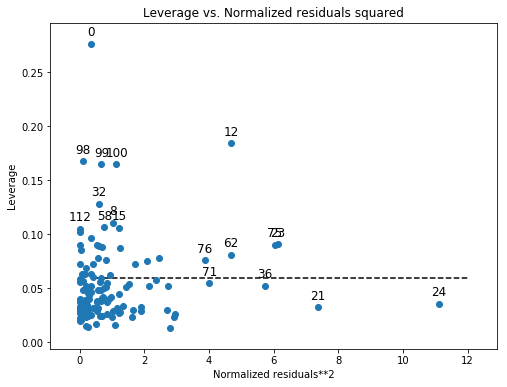

In [77]:
fig, ax = plt.subplots(figsize=(8,6))
fig = plot_leverage_resid2(results, ax = ax)
ax.hlines(y=max_leverage_statistic, xmin=0.5, xmax=12, linestyles='dashed', label='max leverage statistic')

There seem to be a lot of data points with high leverage. This is not quite so good. The problem is that these leverage points could be good or bad: "*Good leverage points and bad leverage points are those outlying observations in the explanatory variables that follow and do not follow the pattern of the majority of the data, respectively.*" (Midi & Mohammed, 2015)

<u>Conclusion:</u><br>
The QQ plot and the Leverage plot suggests there might be room for improvement.<br> 
The QQ plot suggests that our model still sees some data points (more than one clearly) as outliers.<br>
The Leverage plot suggests our fit is more heavily influenced by some data points than others. It is not that easy to identify which leverage points are bad, to be eliminated our weighted down. It is much better to just not have high-leverage points at all.<br>

We could try a model with more complexity.

# Multivariable Polynomial Regression

## Matrix Calculations method

First lets put the data in Matrix format - create a **Design Matrix**<br>
For Multivariable Regression, the Design Matrix, as explained before, is:

$$\mathbf{X}=\begin{vmatrix}
1 & x_{11} & x_{21} & ⋯ & x_{p1} & x_{11}^{2} & x_{21}^{2} & ⋯ & x_{p1}^{2} & ⋯ & x_{p1}^{K}\\
1 & x_{12} & x_{22} & ⋯ & x_{p2} & x_{12}^{2} & x_{22}^{2} & ⋯ & x_{p2}^{2} & ⋯ & x_{p2}^{K}\\
1 & x_{13} & x_{23} & ⋯ & x_{p3} & x_{13}^{2} & x_{23}^{2} & ⋯ & x_{p3}^{2} & ⋯ & x_{p3}^{K}\\
⋮ & ⋮ & ⋮ & ⋮ & ⋮ & ⋮ & ⋮ & ⋮ & ⋮ &⋱ & ⋮\\
1 & x_{1n} & x_{2n} & ⋯ & x_{pn} & x_{1n}^{2} & x_{2n}^{2} & ⋯ & x_{pn}^{2} & ⋯ & x_{pn}^{K}\\
\end{vmatrix}$$

where for the value of K we will decide.

In [78]:
def polynomial_design_matrix_6predictors (x1, x2, x3, x4, x5, x6, order):   

    X = np.ones_like(x1)[:,None]                     #initialise - create the first column of ones
    
    for i in range(order):
        power = i+1
        
        X = np.hstack((X, 
                       x1[:,None]**power, 
                       x2[:,None]**power, 
                       x3[:,None]**power, 
                       x4[:,None]**power, 
                       x5[:,None]**power, 
                       x6[:,None]**power))
    return(X) 

We will now do training and testing of the model using k-fold cross-validation and iterating over several options for powers (K)

Let's create these folds

In [79]:
np.random.seed(1) # fix random seed such that every time we get the same random numbers

n = len(df_cpu_log_train)         # data points
print("data points:", n)

num_folds = 12                    # number of folds, C 

# This block of code is used to generate coordinates for the folds. There are mulitple ways of doing it. 
sizes = np.tile(np.floor(n/num_folds),(1,num_folds))[0] # [0] was added in the end to reduce an unnecessary dimension
sizes[-1] = sizes[-1] + n - sizes.sum()
c_sizes = np.hstack((0, np.cumsum(sizes)))
c_sizes = c_sizes.astype(int)

print("fold intervals:", c_sizes)

data points: 134
fold intervals: [  0  11  22  33  44  55  66  77  88  99 110 121 134]


Let's recap the formula and the response values

In [80]:
print(formula)

PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH


In [81]:
# From before
y_train = np.asanyarray(df_cpu_log_train['PRP'].tolist())

Now let's check for which power the best fit is achieved

([<matplotlib.axis.XTick at 0x1c230d89e8>,
 <a list of 4 Text xticklabel objects>)

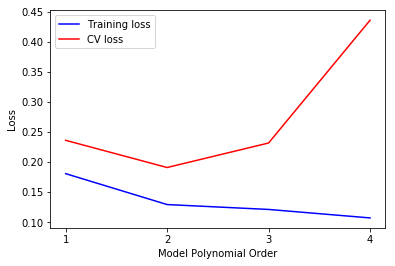

In [82]:
K_max = 4              # the maximum power (order) we will consider

cv_loss = np.zeros((num_folds, K_max))         # preallocate cross validation losses
train_loss = np.zeros((num_folds, K_max))      # preallocate training losses

for k in range(K_max):
    
    power = k + 1                                # ... because k starts at 0
    
    # construct the design matrix over all training data:
    X_design_train = polynomial_design_matrix_6predictors(np.asanyarray(df_cpu_log_train['MMIN'].tolist()),
                                                          np.asanyarray(df_cpu_log_train['MMAX'].tolist()),
                                                          np.asanyarray(df_cpu_log_train['CACH'].tolist()),
                                                          np.asanyarray(df_cpu_log_train['CHMIN'].tolist()), 
                                                          np.asanyarray(df_cpu_log_train['CHMAX'].tolist()),
                                                          np.asanyarray(df_cpu_log_train['CHMAX'].tolist())*np.asanyarray(df_cpu_log_train['CACH'].tolist()),
                                                          power)

    #print("\nFor order: %d"%k)
    for fold in range(num_folds): # iterate over all folds 

        X_design_train_minusfold = np.delete(X_design_train, np.arange(c_sizes[fold], c_sizes[fold+1],1),0)   # select n-C training x 
        y_train_minusfold = np.delete(y_train, np.arange(c_sizes[fold], c_sizes[fold+1],1),0)                 # select n-C training y 
        w_train = least_square(X_design_train_minusfold, y_train_minusfold) # compute least square solution

        X_design_train_fold = X_design_train[c_sizes[fold]:c_sizes[fold+1], :]  # select C testing x 
        y_train_fold = y_train[c_sizes[fold]:c_sizes[fold+1]]                   # select C testing y 
        
        train_loss[fold,k] = loss_lin(w_train, X_design_train_minusfold, y_train_minusfold)    # record training loss at k in the current fold
        cv_loss[fold,k] = loss_lin(w_train, X_design_train_fold, y_train_fold)                 # record cross validation loss at k in the current fold
        
# PLOT THE RESULTS
width_plot = np.arange(K_max)+1 # all tested orders

#print(np.shape(width_plot))
#print(np.shape(train_loss))

plt.plot(width_plot, train_loss.mean(axis=0),'b-', label="Training loss")       # avearage training losses
plt.plot(width_plot, cv_loss.mean(axis=0),'r-', label="CV loss")                # avearage CV losses
plt.legend()
plt.xlabel('Model Polynomial Order')
plt.ylabel('Loss')
plt.xticks(width_plot)

Training data is there to help optimise parameters by reducing the training set loss.<br>
Validation (or cross validation) data is there to ensure increased generalisability, by minimising the validation set loss.<br>
The training loss is typically always lower than the validation loss, but at some point they start to diverge. This seems to be when the polynomial order of 2 was chosen. After this point, the model seems to start overfitting the data.<br><br>
<u>Conclusion:</u>
Polynomical order 2 seems to be the best choice.

In [83]:
X_design_train = polynomial_design_matrix_6predictors(np.asanyarray(df_cpu_log_train['MMIN'].tolist()),
                                                      np.asanyarray(df_cpu_log_train['MMAX'].tolist()),
                                                      np.asanyarray(df_cpu_log_train['CACH'].tolist()),
                                                      np.asanyarray(df_cpu_log_train['CHMIN'].tolist()), 
                                                      np.asanyarray(df_cpu_log_train['CHMAX'].tolist()),
                                                      np.asanyarray(df_cpu_log_train['CHMAX'].tolist())*np.asanyarray(df_cpu_log_train['CACH'].tolist()),
                                                      2)

In [84]:
np.shape(X_design_train)

(134, 13)

In [85]:
y_train = np.asanyarray(df_cpu_log_train['PRP'].tolist())

So let's solve for it

In [86]:
w_least = least_square(X_design_train, y_train)

In [87]:
print(w_least)

[ 4.07222092e+00 -3.30044873e-01 -4.10254458e-01  1.34425610e-01
 -1.22217688e-01  1.49449652e-01 -2.61502875e-02  3.70277198e-02
  4.24715273e-02  8.91259684e-03  9.21108316e-02 -1.51826266e-02
  1.81420223e-03]


Let's create the same arrays for our test data

In [88]:
X_design_test = polynomial_design_matrix_6predictors(np.asanyarray(df_cpu_log_test['MMIN'].tolist()),
                                                     np.asanyarray(df_cpu_log_test['MMAX'].tolist()),
                                                     np.asanyarray(df_cpu_log_test['CACH'].tolist()),
                                                     np.asanyarray(df_cpu_log_test['CHMIN'].tolist()), 
                                                     np.asanyarray(df_cpu_log_test['CHMAX'].tolist()),
                                                     np.asanyarray(df_cpu_log_test['CHMAX'].tolist())*np.asanyarray(df_cpu_log_test['CACH'].tolist()),
                                                     2)
y_test = np.asanyarray(df_cpu_log_test['PRP'].tolist())

In [89]:
np.shape(X_design_test)

(34, 13)

Lets calculate the **loss**

In [90]:
loss_ls = loss_lin(w_least, X_design_test, y_test)
print(loss_ls)

0.20591287539996264


In [91]:
loss_ls < lowest_loss

True

In [92]:
lowest_loss = loss_ls

The is the lowest loss yet.

## Statsmodels method

In [93]:
predictors_order1 = 'MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH'
predictors_order2 = 'np.power(MMIN, 2) + np.power(MMAX, 2) + np.power(CACH, 2) + np.power(CHMIN, 2) + np.power(CHMAX, 2) + np.power(CHMAX * CACH, 2)'

formula = 'PRP ~ ' + predictors_order1 + ' + ' + predictors_order2
formula

'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH + np.power(MMIN, 2) + np.power(MMAX, 2) + np.power(CACH, 2) + np.power(CHMIN, 2) + np.power(CHMAX, 2) + np.power(CHMAX * CACH, 2)'

In [94]:
results = smf.ols(formula, data=df_cpu_log_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PRP   R-squared:                       0.871
Model:                            OLS   Adj. R-squared:                  0.858
Method:                 Least Squares   F-statistic:                     67.86
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           8.01e-48
Time:                        22:37:11   Log-Likelihood:                -54.219
No. Observations:                 134   AIC:                             134.4
Df Residuals:                     121   BIC:                             172.1
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     4.0722      1.338      3.045      0.003       1.424       6.720
MMIN                         -0.3300      0.453     -0.729      0.467      -1.226       0.566
MMAX                         -0.4103      0.414     -0.990      0.324      -1.230       0.410
CACH                          0.1344      0.037      3.618      0.000       0.061       0.208
CHMIN                        -0.1222      0.101     -1.207      0.230      -0.323       0.078
CHMAX                         0.1494      0.116      1.288      0.200      -0.080       0.379
CHMAX:CACH                   -0.0262      0.015     -1.713      0.089      -0.056       0.004
np.power(MMIN, 2)             0.0370      0.032      1.150      0.253      -0.027       0.101
np.power(MMAX, 2)             0.0425      0.025      1.674      0.097      -0.008       0.093
np.power(CACH, 2)             0.0089      0.014      0.628      0.531      -0.019       0.037
np.power(CHMIN, 2)            0.0921      0.047      1.942      0.055      -0.002       0.186
np.power(CHMAX, 2)           -0.0152      0.025     -0.618      0.538      -0.064       0.033
np.power(CHMAX * CACH, 2)     0.0018      0.001      1.639      0.104      -0.000       0.004
==============================================================================
Omnibus:                        5.783   Durbin-Watson:                   1.522
Prob(Omnibus):                  0.055   Jarque-Bera (JB):                6.900
Skew:                           0.254   Prob(JB):                       0.0317
Kurtosis:                       3.988   Cond. No.                     5.87e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.87e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Whilst the loss improved (decreased) as previously calculated, other statistical metrics have worsened:<br>
- Looking at the F-statistic: It has decreased by 30%, implying there is less certainty of a relationship between predictors and response.
- Looking at the p-values: In line with the F-statistic, all the predictors have become statistically insignificant, except for CACH. This means collinearity is causing havoc with our model.
- Looking at the Condition number. It has increased by a factor of 44, indicating there could be multi-collinearity. However, the calculation of the VIF is important here to verify, and as shown below, multi-collinearity is significant. 

In [95]:
VIF(df_cpu_log_train, formula)

,VIF,variable
0,1645.995059,Intercept
1,224.309583,MMIN
2,181.464036,MMAX
3,9.036141,CACH
4,10.278010,CHMIN
5,20.810198,CHMAX
6,11.620253,CHMAX:CACH
7,249.599456,"np.power(MMIN, 2)"
8,195.396865,"np.power(MMAX, 2)"
9,6.755410,"np.power(CACH, 2)"


At this point, one could be tempted to try different combinations of order 2 terms.<br>
The only order 2 term above that seemed to nearly have statistical significance, is CHMIN, so we could try that.

In [96]:
predictors_order1 = 'MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH'
predictors_order2 = 'np.power(CHMIN, 2)'

formula = 'PRP ~ ' + predictors_order1 + ' + ' + predictors_order2
formula

'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH + np.power(CHMIN, 2)'

In [97]:
results = smf.ols(formula, data=df_cpu_log_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PRP   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.832
Method:                 Least Squares   F-statistic:                     95.21
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           3.24e-47
Time:                        22:37:11   Log-Likelihood:                -68.039
No. Observations:                 134   AIC:                             152.1
Df Residuals:                     126   BIC:                             175.3
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.5304      0.382     -1.389      0.167      -1.286       0.225
MMIN                   0.1957      0.053      3.688      0.000       0.091       0.301
MMAX                   0.2773      0.054      5.122      0.000       0.170       0.384
CACH                   0.1007      0.035      2.860      0.005       0.031       0.170
CHMIN                 -0.0649      0.076     -0.859      0.392      -0.215       0.085
CHMAX                  0.1494      0.044      3.421      0.001       0.063       0.236
CHMAX:CACH             0.0050      0.013      0.387      0.699      -0.021       0.031
np.power(CHMIN, 2)     0.1206      0.030      4.055      0.000       0.062       0.179
==============================================================================
Omnibus:                        5.998   Durbin-Watson:                   1.333
Prob(Omnibus):                  0.050   Jarque-Bera (JB):                9.529
Skew:                          -0.052   Prob(JB):                      0.00853
Kurtosis:                       4.302   Cond. No.                         140.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

This looks good except for the fact that the interactive term CHMAX*CACH has become statistically insignificant. Let's remove it.

In [98]:
predictors_order1 = 'MMIN + MMAX + CACH + CHMIN + CHMAX'
predictors_order2 = 'np.power(CHMIN, 2)'

formula = 'PRP ~ ' + predictors_order1 + ' + ' + predictors_order2
formula

'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + np.power(CHMIN, 2)'

In [99]:
results = smf.ols(formula, data=df_cpu_log_train).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    PRP   R-squared:                       0.841
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     111.8
Date:                Sun, 06 Sep 2020   Prob (F-statistic):           3.15e-48
Time:                        22:37:11   Log-Likelihood:                -68.119
No. Observations:                 134   AIC:                             150.2
Df Residuals:                     127   BIC:                             170.5
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.5204      0.380     -1.371      0.173      -1.272       0.231
MMIN                   0.1958      0.053      3.702      0.000       0.091       0.300
MMAX                   0.2756      0.054      5.124      0.000       0.169       0.382
CACH                   0.1127      0.017      6.697      0.000       0.079       0.146
CHMIN                 -0.0786      0.067     -1.180      0.240      -0.210       0.053
CHMAX                  0.1532      0.042      3.615      0.000       0.069       0.237
np.power(CHMIN, 2)     0.1275      0.024      5.366      0.000       0.080       0.174
==============================================================================
Omnibus:                        5.825   Durbin-Watson:                   1.327
Prob(Omnibus):                  0.054   Jarque-Bera (JB):                9.052
Skew:                          -0.056   Prob(JB):                       0.0108
Kurtosis:                       4.268   Cond. No.                         129.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

These seem to be the best statistical results yet, but what of the loss?

First let's create the Design Matrix using our chosen predictors (formula), and also the response array:

In [100]:
y_train_df, X_design_train_df = dmatrices(formula, data=df_cpu_log_train, return_type='dataframe')

X_design_train = X_design_train_df.to_numpy()
print(np.shape(X_design_train))

(134, 7)


In [101]:
y_train = y_train_df.to_numpy()
print(np.shape(y_train))

(134, 1)


Then let's use the Least Squares Method (which worked out best earlier) to obtain the coefficients matrix:

In [102]:
w_least = least_square(X_design_train, y_train)[:,0]
print(w_least)

[-0.52042248  0.19575066  0.27562115  0.11266393 -0.07858513  0.15321039
  0.12746397]


Then let's transform our test data in a similar fasion to a Design Matrix for X and response array for Y:

In [103]:
y_test_df, X_design_test_df = dmatrices(formula, data=df_cpu_log_test, return_type='dataframe')

X_design_test = X_design_test_df.to_numpy()
print(np.shape(X_design_test))

(34, 7)


Finally we can calculate the loss

In [104]:
loss_ls = loss_lin(w_least, X_design_test, y_test)
print(loss_ls)

0.27556180086069526


Question: Is the loss produced by this method the lowest so far?

In [105]:
loss_ls < lowest_loss

False

The loss we achieved is not the best so far, but is better than any solution tried with Univariable Regression. It is only less than the loss achieved by including the interactive terms and all the order two terms. But in that sense it is arguably the best result in being the lowest loss achieved by a model that is statistically sound, and by statistically sound it means there is no multi-collinearity making results more interpretable.

Howerver, according to Allison (2012) there are three situations in which high multi-collinearity (as calculated by using the VIF) can be safely ignored. In his document he states condition 2 as:<br>
*<u>The high VIFs are caused by the inclusion of powers or products of other variables.</u> If you specify a regression model with both $x$ and $x^{2}$, there’s a good chance that those two variables will be highly correlated. Similarly, if your model has $x$, $z$, and $xz$, both $x$ and $z$ are likely to be highly correlated with their product. This is not something to be concerned about, however, because the p-value for $xz$ is not affected by the multicollinearity.  This is easily demonstrated: you can greatly reduce the correlations by “centering” the variables (i.e., subtracting their means) before creating the powers or the products. But the p-value for $x^{2}$ or for $xz$ will be exactly the same, regardless of whether or not you center. And all the results for the other variables (including the $R^{2}$ but not including the lower-order terms) will be the same in either case. So the multicollinearity has no adverse consequences.*

"*Is this a problem? Well, it does mean that p-values for the indicator variables may be high. But the overall test that all indicators have coefficients of zero is unaffected by the high VIFs.*" (Allison, 2012) This means the main metric should be the F-statistic then.

This seems to be a point for debate then, but at least we have two options<br>

<u>Option 1:</u> Producing the lowest loss but having high VIF and higher SE values for each predictor; with a lower F-statistic:

In [106]:
predictors_order1 = 'MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH'
predictors_order2 = 'np.power(MMIN, 2) + np.power(MMAX, 2) + np.power(CACH, 2) + np.power(CHMIN, 2) + np.power(CHMAX, 2) + np.power(CHMAX * CACH, 2)'

formula_option1 = 'PRP ~ ' + predictors_order1 + ' + ' + predictors_order2
formula_option1

'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + CHMAX * CACH + np.power(MMIN, 2) + np.power(MMAX, 2) + np.power(CACH, 2) + np.power(CHMIN, 2) + np.power(CHMAX, 2) + np.power(CHMAX * CACH, 2)'

<u> Option 2:</u> Producing a slightly higher loss, but having all other statistical indicators better:

In [107]:
formula_option2 = 'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + np.power(CHMIN, 2)'
formula_option2

'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + np.power(CHMIN, 2)'

This might arguably be the 'good enough' option.

Lets look at some diagnostics plots for option 2:

In [108]:
formula = formula_option2
results = smf.ols(formula, data=df_cpu_log_train).fit()

In [109]:
results_influence = OLSInfluence(results)

In [110]:
print(results_influence)

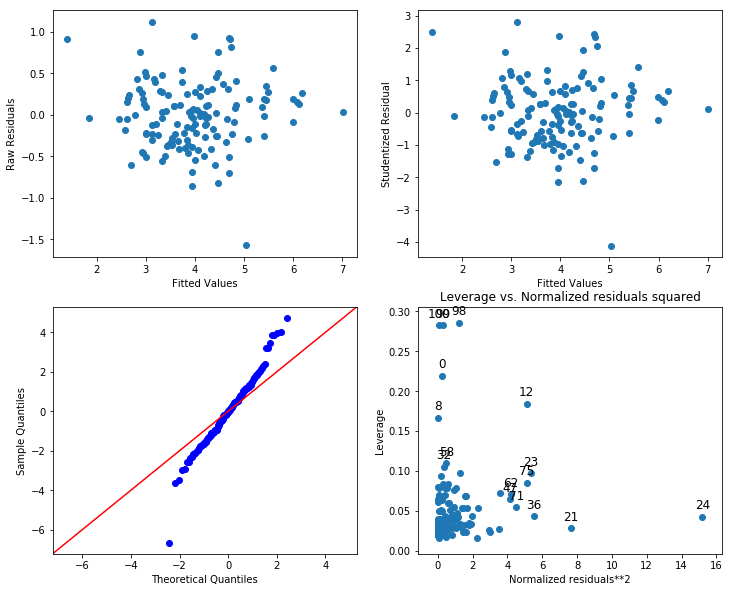

In [111]:
# make four diagnostics plots
fig, ax = plt.subplots(2, 2, figsize=(12,10))                # make a 2x2 plot

# making the residual plot (top left)
ax[0, 0].scatter(results.fittedvalues, results.resid)         
ax[0, 0].set_ylabel("Raw Residuals")
ax[0, 0].set_xlabel("Fitted Values")

# making a studentized residual plot (top right)
ax[0, 1].scatter(results.fittedvalues, results_influence.resid_studentized_external)
ax[0, 1].set_ylabel("Studentized Residual")
ax[0, 1].set_xlabel("Fitted Values")

# qq plot (bottom left)
sm.graphics.qqplot(results.resid / np.sqrt((results.resid ** 2).sum() / 390), line='45', ax=ax[1, 0]);

# leverage plot (bottom right)
plot_leverage_resid2(results, ax = ax[1, 1]);

The plots do not look that much better than under the Univariable Regression diagnostic plots.

# Predictions

Up to this point, we have worked in a logarithmic scale ($ln(x)$) for our calculations: <br>Our interactive terms and polynomial terms were calculated that way.<br>More, importantly, our coefficients were caclulated that way;<br>
Now with predictions we will be converting the answers back to their normal form ($e^{x}$).<br>

However, we need to be careful:<br> 
Looking at the first record for predictor *np.power(CHMIN,2)* ...<br>
...we cannot say it is: $16.16=256$.<br>
...we must say it is: $e^{(ln(16).ln(16))}=2180.37$<br>
Thus, work in log terms as you did before for all calculations until the end, where you convert the answer back.

In [112]:
# creating a design matrix over the entire dataset
# using the dataframe with the log values
PRP, df_cpu_new = dmatrices(formula, data=df_cpu_log, return_type='dataframe')
X_design = df_cpu_new

In [113]:
df_cpu_new.head()

,Intercept,MMIN,MMAX,CACH,CHMIN,CHMAX,"np.power(CHMIN, 2)"
0,1.0,5.545177,8.699515,5.545177,2.772589,4.852030,7.687248
1,1.0,8.987197,10.373491,3.465736,2.079442,3.465736,4.324077
2,1.0,8.987197,10.373491,3.465736,2.079442,3.465736,4.324077
3,1.0,8.987197,10.373491,3.465736,2.079442,3.465736,4.324077
4,1.0,8.987197,10.373491,4.158883,2.079442,3.465736,4.324077


For our predictions then:

$$\hat{y}=X.w_{train}$$

In [114]:
y_pred = np.dot(X_design, w_least)

Now that we have our predictions lets go back to the normal scale

In [115]:
PRP_pred = np.exp(y_pred)

#### Data frame with original response

In [116]:
df_cpu_new.head()

,Intercept,MMIN,MMAX,CACH,CHMIN,CHMAX,"np.power(CHMIN, 2)"
0,1.0,5.545177,8.699515,5.545177,2.772589,4.852030,7.687248
1,1.0,8.987197,10.373491,3.465736,2.079442,3.465736,4.324077
2,1.0,8.987197,10.373491,3.465736,2.079442,3.465736,4.324077
3,1.0,8.987197,10.373491,3.465736,2.079442,3.465736,4.324077
4,1.0,8.987197,10.373491,4.158883,2.079442,3.465736,4.324077


In [117]:
df_cpu_new = df_cpu_new.iloc[:,1:]      # lets remove the intercept column

Add response data to the dataframe

In [118]:
# add array of values of lables to the dataframe
df_cpu_new['PRP'] = PRP

In [119]:
# Put response data column in front:

# get a list of columns
cols = list(df_cpu_new)
# move the column to the front of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('PRP')))
# use loc to reorder
df_cpu_new = df_cpu_new.loc[:, cols]

In [120]:
df_cpu_new.head()

,PRP,MMIN,MMAX,CACH,CHMIN,CHMAX,"np.power(CHMIN, 2)"
0,5.288267,5.545177,8.699515,5.545177,2.772589,4.852030,7.687248
1,5.594711,8.987197,10.373491,3.465736,2.079442,3.465736,4.324077
2,5.393628,8.987197,10.373491,3.465736,2.079442,3.465736,4.324077
3,5.147494,8.987197,10.373491,3.465736,2.079442,3.465736,4.324077
4,5.762051,8.987197,10.373491,4.158883,2.079442,3.465736,4.324077


And finally let's convert the entire dataframe to the natural form

In [121]:
df_cpu_new = df_cpu_new.apply(np.exp)

In [122]:
df_cpu_new.head()

,PRP,MMIN,MMAX,CACH,CHMIN,CHMAX,"np.power(CHMIN, 2)"
0,198.0,256.0,6000.0,256.0,16.0,128.0,2180.366417
1,269.0,8000.0,32000.0,32.0,8.0,32.0,75.495808
2,220.0,8000.0,32000.0,32.0,8.0,32.0,75.495808
3,172.0,8000.0,32000.0,32.0,8.0,32.0,75.495808
4,318.0,8000.0,32000.0,64.0,8.0,32.0,75.495808


#### Dataframe with the predicted response

In [123]:
df_cpu_new_pred = df_cpu_new.iloc[:,1:]    # taking the original dataframe (we just created) minus the PRP column

Add the predicted response data to the dataframe

In [124]:
df_cpu_new_pred['PRP'] = PRP_pred

In [125]:
# Put response data column in front:

# get a list of columns
cols = list(df_cpu_new_pred)
# move the column to the front of list using index, pop and insert
cols.insert(0, cols.pop(cols.index('PRP')))
# use loc to reorder
df_cpu_new_pred = df_cpu_new_pred.loc[:, cols]

In [126]:
df_cpu_new_pred.head()

,PRP,MMIN,MMAX,CACH,CHMIN,CHMAX,"np.power(CHMIN, 2)"
0,162.862415,256.0,6000.0,256.0,16.0,128.0,2180.366417
1,223.002237,8000.0,32000.0,32.0,8.0,32.0,75.495808
2,223.002237,8000.0,32000.0,32.0,8.0,32.0,75.495808
3,223.002237,8000.0,32000.0,32.0,8.0,32.0,75.495808
4,241.115118,8000.0,32000.0,64.0,8.0,32.0,75.495808


## Plots

Let's plot our prediction vs the actual data for the entire data set

In [127]:
def plot_two_rowed_figure_predictions(num_cols, num_rows, num_predictors, response_name, dataframe_pred, style='b-', log_scale=False, plot_orig_data=False, dataframe_orig=pd.DataFrame()):
    
    # Scatter plots of each independent variable against the dependent variable
    fig = plt.figure(figsize=(8*num_cols, 4*num_rows))

    for i in range(p):
        plot_number=i+1
        
        ax = fig.add_subplot(num_rows, num_cols, plot_number)
        

        if plot_orig_data == True:
            """   
            If you want to plot the original data to compare to the predicted that you can...
            """  
            # original plot
            ax.scatter(np.asanyarray(dataframe_orig.iloc[:, i+1].tolist()), 
                       np.asanyarray(dataframe_orig[response_name].tolist()), 
                       alpha=0.3)
        
        # predicted plot
        """
        Here, in order to plot a fitted line, 
        it is always important to sort the dataframe by the predictor in question each time
        """
        ax.plot(np.asanyarray(dataframe_pred.sort_values(list(dataframe_pred)[i+1])[list(dataframe_pred)[i+1]]),
                np.asanyarray(dataframe_pred.sort_values(list(dataframe_pred)[i+1])[response_name]),
                style)
            
        ax.set_title(response_name + " vs " + dataframe_pred.columns[i+1])
        ax.set_xlabel(dataframe_pred.columns[i+1])
        ax.set_ylabel(response_name)
        
        if log_scale == True:
            ax.set_yscale('log')
            ax.set_xscale('log')

    plt.tight_layout()  

In [128]:
p = len(df_cpu_new.iloc[:,1:].columns)               # predictors (variables) - counting the columns (excl. response)

fig_cols = 2                                         # number of columns in the multifaceted figure
fig_rows = int(p / fig_cols)                         # number of rows in the multifaceted figure

Let's look at the plots in log form first.

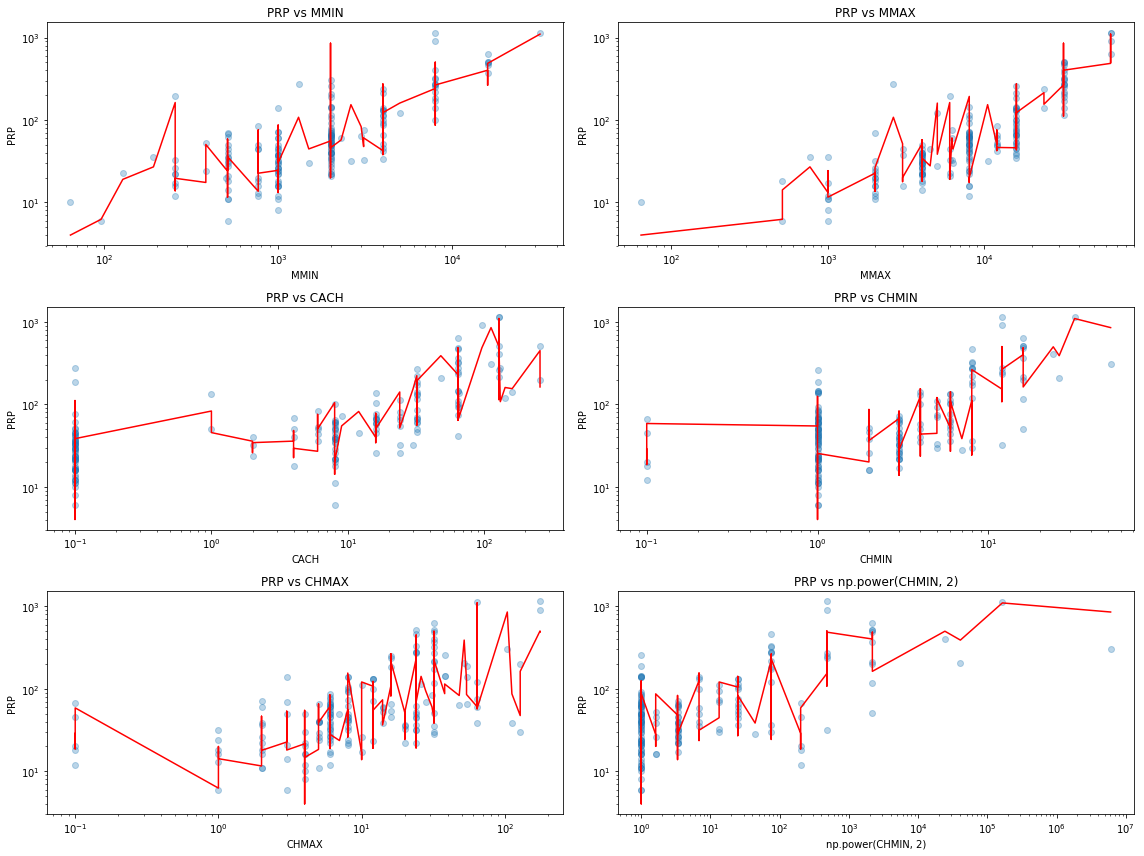

In [129]:
plot_two_rowed_figure_predictions(fig_cols, fig_rows, p, 'PRP', df_cpu_new_pred,
                                  style='r-', log_scale=True,
                                  plot_orig_data=True, dataframe_orig=df_cpu_new)

Let's look at the plots in normal form then.

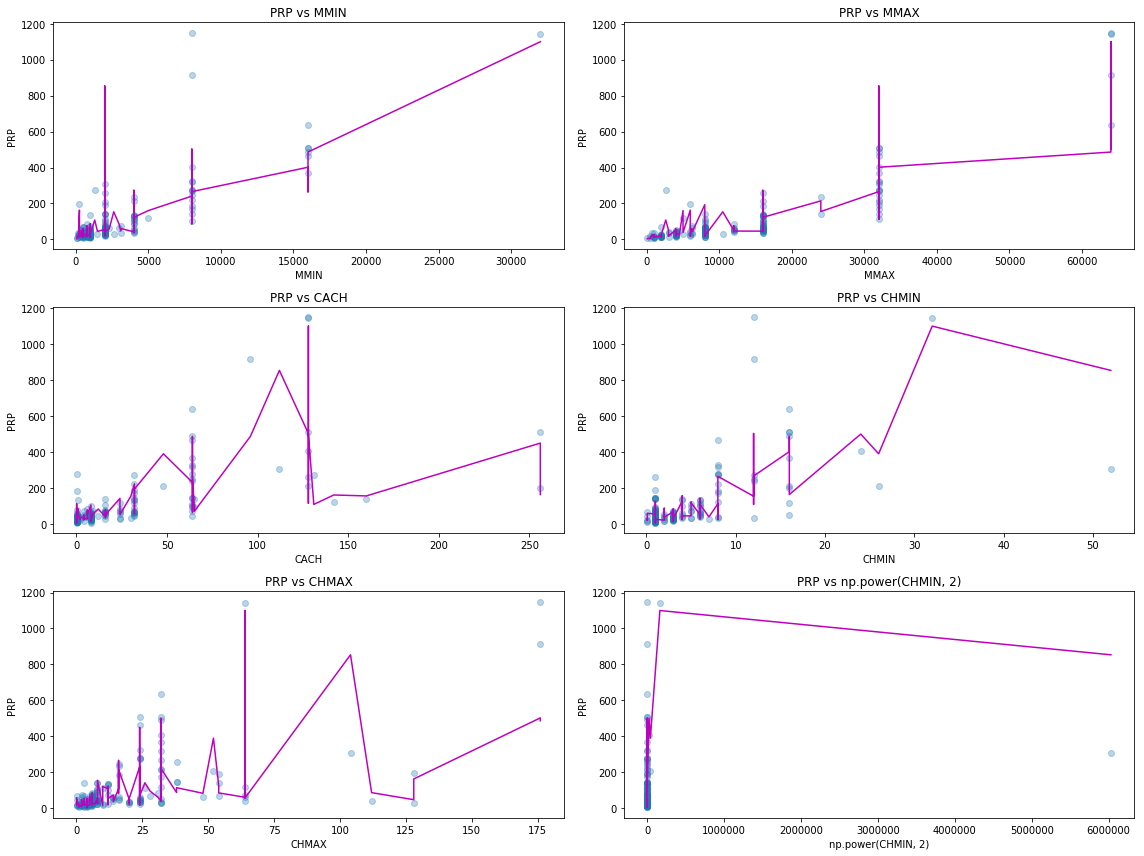

In [130]:
plot_two_rowed_figure_predictions(fig_cols, fig_rows, p, 'PRP', df_cpu_new_pred,
                                  style='m-', log_scale=False,
                                  plot_orig_data=True, dataframe_orig=df_cpu_new)

## Individual predictions

At this point we can create a function using our preferred formula and its coefficients to make predictions.

In [131]:
formula

'PRP ~ MMIN + MMAX + CACH + CHMIN + CHMAX + np.power(CHMIN, 2)'

In [132]:
def PRP_prediction(predictors_dataframe, coefficients):
    """
    This function requires the input of a pandas dataframe with the necessary column headers labeled properly as:
    'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX'
    """
    MMIN = np.asanyarray(predictors_dataframe['MMIN'])
    MMAX = np.asanyarray(predictors_dataframe['MMAX'])
    CACH = np.asanyarray(predictors_dataframe['CACH'])
    CHMIN = np.asanyarray(predictors_dataframe['CHMIN'])
    CHMAX = np.asanyarray(predictors_dataframe['CHMAX'])
    
    """
    So, because we worked in log scale when calculating the coefficients, lets go back to log scale ...
    """
    MMIN = np.log(MMIN)
    MMAX = np.log(MMAX)
    CACH = np.log(CACH)
    CHMIN = np.log(CHMIN)
    CHMAX = np.log(CHMAX)
    """
    ... calculate our prediction ...
    """
    PRP = np.ones_like(MMIN)
    PRP = coefficients[0] + coefficients[1]*MMIN + coefficients[2]*MMAX + coefficients[3]*CACH + \
          coefficients[4]*CHMIN + coefficients[5]*CHMAX + coefficients[6]*np.power(CHMIN,2)
  
    """
    ... and then come back to the normal scale
    """    
    PRP = np.exp(PRP)
    
    return PRP
    

We could import from an excel spreadsheet into a pandas dataframe much like in the beginning of this project, or ...<br>we could create a dataframe just for a single sample (datapoint), for which we want to predict the response.<br> Let's attempt the latter here.

In [133]:
cpu = {'MMIN': [256],
       'MMAX': [6000],
       'CACH' : [256],
       'CHMIN' : [16],
       'CHMAX' : [128]       
        }

df_cpu_sample = pd.DataFrame(cpu, columns = ['MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX'])

In [134]:
df_cpu_sample.head()

,MMIN,MMAX,CACH,CHMIN,CHMAX
0,256,6000,256,16,128


In [135]:
PRP_prediction(df_cpu_sample, results.params)

array([162.862415])

## Prediction intervals

Confidence Interval:<br>
$$\hat{y}_{p}±t_{\alpha/2}.se\sqrt{\frac{1}{n}+\frac{(x_{p}-\bar{x})^{2}}{s_{xx}}}$$
Prediction Interval:<br>
$$\hat{y}_{p}±t_{\alpha/2}.se\sqrt{1+\frac{1}{n}+\frac{(x_{p}-\bar{x})^{2}}{s_{xx}}}$$

$t_{\alpha/2}$ is the 100(1 − $\alpha$/2)th percentile of Student's t-distribution with n − 1 degrees of freedom.<br>
<u>Note:</u> This is not to be confused with the t-statistic that was calculated when attempting to reject the Hypotheses test that predictors and response have no relationship.<br> The t-value can be obtained by looking at the t-distrubtion table or simply using the sci-py library.<br><br>
$se$ is the standard error (or the RSE). We have already calculated the RSE for each coefficient earlier:

In [136]:
results.bse

Intercept             0.379697
MMIN                  0.052879
MMAX                  0.053789
CACH                  0.016824
CHMIN                 0.066621
CHMAX                 0.042387
np.power(CHMIN, 2)    0.023756
dtype: float64

In [137]:
def create_interval(std_error, coefficients, interval_type, alpha, predictors_dataframe, sample_dataframe):
    if interval_type == 'confidence':
        add_one = 0
    elif interval_type == 'prediction':
        add_one = 1
    else:
        print("Choose interval_type as confidence or prediction")
        return

    """
    This function requires the input of pandas dataframes with the necessary column headers labeled properly as:
    'MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX'
    """    
    # This is our dataframe with all our original data
    dataframe = predictors_dataframe.replace(0, 0.1, regex=True)
    MMIN = np.asanyarray(dataframe['MMIN'])
    MMAX = np.asanyarray(dataframe['MMAX'])   
    CACH = np.asanyarray(dataframe['CACH'])    
    CHMIN = np.asanyarray(dataframe['CHMIN'])    
    CHMAX = np.asanyarray(dataframe['CHMAX'])
    MMIN = np.log(MMIN)
    MMAX = np.log(MMAX)
    CACH = np.log(CACH)
    CHMIN = np.log(CHMIN)
    CHMAX = np.log(CHMAX)  
    # This is our dataframe with our sample data point(s)
    dataframe = sample_dataframe.replace(0, 0.1, regex=True)
    MMIN_p = np.asanyarray(dataframe['MMIN'])
    MMAX_p = np.asanyarray(dataframe['MMAX'])
    CACH_p = np.asanyarray(dataframe['CACH'])
    CHMIN_p = np.asanyarray(dataframe['CHMIN'])
    CHMAX_p = np.asanyarray(dataframe['CHMAX'])
    MMIN_p = np.log(MMIN_p)
    MMAX_p = np.log(MMAX_p)
    CACH_p = np.log(CACH_p)
    CHMIN_p = np.log(CHMIN_p)
    CHMAX_p = np.log(CHMAX_p)
    
    t_value = stats.t.ppf(1 - alpha / 2, df = n - 2)    

    """
    Interval(s) calculations for each predictor
    """    
    #MMIN
    interval_MMIN = t_value * \
                    std_error[1] * \
                    np.sqrt(add_one + 1 / n + (((MMIN_p - MMIN.mean()) ** 2)/((MMIN - MMIN.mean()) ** 2).sum()))
    
    #MMAX
    interval_MMAX = t_value * \
                    std_error[2] * \
                    np.sqrt(add_one + 1 / n + (((MMAX_p - MMAX.mean()) ** 2)/((MMAX - MMAX.mean()) ** 2).sum())) 
    #CACH
    interval_CACH = t_value * \
                    std_error[3] * \
                    np.sqrt(add_one + 1 / n + (((CACH_p - CACH.mean()) ** 2)/((CACH - CACH.mean()) ** 2).sum())) 
    #CHMIN
    interval_CHMIN = t_value * \
                     std_error[4] * \
                     np.sqrt(add_one + 1 / n + (((CHMIN_p - CHMIN.mean()) ** 2)/((CHMIN - CHMIN.mean()) ** 2).sum())) 
    #CHMAX
    interval_CHMAX = t_value * \
                     std_error[5] * \
                     np.sqrt(add_one + 1 / n + (((CHMAX_p - CHMAX.mean()) ** 2)/((CHMAX - CHMAX.mean()) ** 2).sum()))     

    
    interval = interval_MMIN + interval_MMAX + interval_CACH + interval_CHMIN + interval_CHMAX    
    
    """
    Prediction(s) calculations
    """
    prediction = np.ones_like(MMIN_p)
    prediction = coefficients[0] + coefficients[1]*MMIN_p + coefficients[2]*MMAX_p + coefficients[3]*CACH_p + \
                 coefficients[4]*CHMIN_p + coefficients[5]*CHMAX_p + coefficients[6]*np.power(CHMIN_p,2) 

    """
    Prediction(s) with intervals calculations
    """    
    
    lower_bound = prediction - interval
    upper_bound = prediction + interval
    
    lower_bound = np.exp(lower_bound)
    upper_bound = np.exp(upper_bound)
    
    return (lower_bound[0], upper_bound[0])

In [138]:
cpu = {'MMIN': [256],
       'MMAX': [6000],
       'CACH' : [256],
       'CHMIN' : [16],
       'CHMAX' : [128]       
        }

df_cpu_sample = pd.DataFrame(cpu, columns = ['MMIN', 'MMAX', 'CACH', 'CHMIN', 'CHMAX'])

In [139]:
df_cpu_sample.head()

,MMIN,MMAX,CACH,CHMIN,CHMAX
0,256,6000,256,16,128


In [140]:
create_interval(results.bse, results.params, 'confidence', .05, df_cpu, df_cpu_sample)

(152.45937698232157, 173.97530243378654)

In [141]:
create_interval(results.bse, results.params, 'prediction', .05, df_cpu, df_cpu_sample)

(102.31615830351998, 259.23731558296356)

<u>Confidence Interval:</u><br>
We can say that: at the data point (256, 6000, 356, 16, 128):<br>
there is a 95% probability that the model (line) fits between these two bounds (152.46, 173.98).<br>
<u>Prediction Interval:</u><br>
We can say that: at the data point (256, 6000, 356, 16, 128):<br>
95% of the observations (response predictions) will fall between these two bound (102.32, 259.24).

# References:<br>

Allison, P., 2012. When Can You Safely Ignore Multicollinearity?. [Online] 
Available at: https://statisticalhorizons.com/multicollinearity
[Accessed 30 August 2020].

Geeks for Geeks, 2020. Cache Memory in Computer Organization. [Online] 
Available at: https://www.geeksforgeeks.org/cache-memory-in-computer-organization/
[Accessed 23 August 2020].

Heddings, A., 2020. HTG Explains: How Does a CPU Actually Work?. [Online] 
Available at: https://www.howtogeek.com/367931/htg-explains-how-does-a-cpu-actually-work/
[Accessed 23 August 2020].<br>

James, G., Witten, D., Hastie, T. & Tibshirani, R., 2017. An Introduction to Statistical Learning with Applications in R. New York: Springer.

Midi, H. & Mohammed, M. A., 2015. The Identification of Good and Bad High Leverage Points in Multiple Linear Regression Model. Mathematical Methods and Systems in Science and Engineering.

SAS, n.d. Support - Understanding an insignificant intercept and whether to remove it from the model. [Online] 
Available at: http://support.sas.com/kb/23/136.html
[Accessed 23 August 2020].

Yuan, K., 2018. Machine Learning H/M Coursework 2018. Glasgow: University of Glasgow.<br>

Zhou, Q., Xue, F. & Zhao, L., n.d. Evaluating CPU Performance: an Exploration of the Estimation of Relative Performance. 